

-# Install packages

In [1]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install statsmodels
# !pip install fuzzywuzzy
# !pip install python-Levenshtein
# !pip install scikit-learn
# !pip install imblearn
# !pip install xgboost
# !pip install lightgbm
# !pip install keras
# !pip install dill

# Import libraries

In [2]:
## Data loading and manipulation
from pandas import read_csv
from pandas import DataFrame
from pandas import to_datetime
from pandas import to_numeric
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from pandas import CategoricalDtype
from numpy import nan as nan_value
from pandas import concat
from pandas import cut
from numpy import quantile
from numpy import linspace
from numpy import concatenate
from numpy import inf as np_inf
from fuzzywuzzy import process

## EDA
import matplotlib.pyplot as plt
from pandas import DatetimeIndex
import seaborn as sns
from IPython.display import Image

## Feature Engineering
from scipy import stats
from numpy import log
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data pre-processing
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

## Model building
from sklearn.model_selection import RandomizedSearchCV

# Linear models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Support Vector Machines
from sklearn.svm import SVC

# Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Neural Networks
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import Adam

## Model Evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Saving model
import joblib
import pickle

## Other imports
from os import listdir
from os import makedirs
from os.path import exists
from os import environ
import time
from datetime import datetime
import time
from datetime import timedelta
import dill

# Project configurations

In [3]:
DATA_DIR = 'data'
EDA_REPORTS_DIR = 'eda'
TRANSFORMATIONS_DIR = 'transformations'
CROSS_VALIDATION_DIR = 'cv_results'
MODEL_FITTING_RESULTS_DIR = 'model_fitting'
MODEL_DEPLOYMENT_DIR = 'deployed_models'

In [4]:
makedirs(DATA_DIR, exist_ok=True)
makedirs(EDA_REPORTS_DIR, exist_ok=True)
makedirs(MODEL_DEPLOYMENT_DIR, exist_ok=True)
makedirs(TRANSFORMATIONS_DIR, exist_ok=True)
makedirs(CROSS_VALIDATION_DIR, exist_ok=True)
makedirs(MODEL_FITTING_RESULTS_DIR, exist_ok=True)

# Data transformation module

In [5]:
class TransformationModule:
    def __init__(self):
        self.transformations = []

    def add_transformation(self, func, *args, **kwargs):
        """
        Add a transformation function to the list of transformations.
        """
        self.transformations.append((func, args, kwargs))

    def apply_transformations(self, _df: DataFrame):
        """
        Apply all stored transformations to the DataFrame in order.
        """
        for func, args, kwargs in self.transformations:
            print('\nApplying transformation: {}'.format(func.__name__))
            print('Before transformation: {}'.format(_df.shape))
            _df = func(_df, *args, **kwargs)
            print('After transformation: {}'.format(_df.shape))
        return _df

    def __getstate__(self):
        """
        Called when pickling the object. Ensures all attributes are picklable.
        """
        return self.__dict__

    def __setstate__(self, state):
        """
        Called when unpickling the object. Restores the object's state.
        """
        self.__dict__.update(state)


# Data Cleaning

- 🧹 Perform data expectation exercise (because no details about variables were provided)
- 🧹 Remove all duplicate rows and columns (generally one of the first step in data cleaning)
- 🧹 Based on expectation, set variables to their expected data types
- 🧹 Treat empty, missing, or null data values
- 🧹 Format text to take a standard form
- 🧹 Treat typos or misrepresented entries
- 🧹 Prepare categories for categorical data

## Section helper methods

### Investigation methods

**`gather_data_expectaction`** - Designed to collect information about the expected characteristics of columns in a loan dataset. It allows time to research, gather knowlegde

In [6]:
def gather_data_expectaction(_column_list: list) -> DataFrame:
    data_type_mapping: dict = {'1': 'numerical', '2': 'text', '3': 'date', '4': 'boolean'}
    categorical_mapping: dict = {'0': False, '1': True}
    data_expectation: dict = dict()
    for column in _column_list:
        description_input = input('\n\nBrief description of a "{}" column in a loan dataset -> '.format(column))
        print('---')
        data_type_expectation = input('Data type I would expect for a "{}" column:\n1 for numerical\n2 for text\n3 for date\n4 for boolean\n -> '.format(column))
        print('---')
        is_categorical = input('Could column "{}" be categorical?:\n0 for no\n1 for yes -> '.format(column))
        print('---')

        # Default settings
        if not data_type_expectation:
            data_type_expectation = '2'

        if not is_categorical:
            is_categorical = '0'

        data_expectation[column] = {
            'description': description_input,
            'expected type': data_type_mapping.get(data_type_expectation),
            'expected categorical': categorical_mapping.get(is_categorical)
        }

    data_expectation = DataFrame(data_expectation)
    data_expectation = data_expectation.transpose()
    data_expectation = data_expectation.reset_index()
    data_expectation = data_expectation.rename(columns={'index': 'column'})

    return data_expectation

**`find_duplicate_columns_list`** - Designed to find duplicate columns

In [7]:
def find_duplicate_columns_list(_df: DataFrame, identity_perc_threshold: float) -> list[tuple]:
    number_of_rows = _df.shape[0]
    _columns_list = _df.columns.to_list()

    duplicate_set_list: list = list()

    # Iterate through all columns
    for _anchor_column in _columns_list:

        # Create a check column list which excludes the anchor column
        check_columns = [column for column in _columns_list if column != _anchor_column]

        # Iterate through all check columns
        for check_column in check_columns:

            # Test whether anchor and check column are identical
            df_check = _df[_anchor_column] == _df[check_column]
            identical_rows = df_check.sum()

            # When the proportion of number of identical rows is at least the threshold
            if (identical_rows / number_of_rows) * 100 >= identity_perc_threshold:
                duplicate_set_list.append((_anchor_column, check_column))

    return duplicate_set_list

**`find_null_columns`** - Designed to return list of null values for text and numerical variables in a dataframe 

In [8]:
def find_null_columns(_df: DataFrame) -> tuple:
    """
    Identifies numeric and text columns with null values in the DataFrame.
    """
    _numeric_columns_with_null: list = list()
    _text_columns_with_null: list = list()
    
    for _column in _df.columns:
        _df_column = _df[_column]
        
        # Check if the column is numeric
        is_numeric = is_numeric_dtype(_df_column)
        # Check if the column is text
        is_text = is_string_dtype(_df_column)
        
        # When column has null values
        if _df_column.isnull().any():
            # When column is numeric
            if is_numeric:
                _numeric_columns_with_null.append(_column)
            # When column is text
            if is_text or (str(_df_column.dtype) == 'object'):
                _text_columns_with_null.append(_column)
    
    return _numeric_columns_with_null, _text_columns_with_null

In [9]:
def get_numerical_columns(_df: DataFrame) -> list():
    _df_columns = _df.columns.to_list()

    _numerical_cols:list = list()
    # Iterate through all columns
    for column in _df_columns:

        # When data type is numerical
        if is_numeric_dtype(_df[column]):
            _numerical_cols.append(column)

    return _numerical_cols

In [10]:
def get_text_columns(_df: DataFrame, category_perc_threshold: float) -> list:
    _df_rows = _df.shape[0]
    max_unique_values = (category_perc_threshold / 100) * _df_rows
    text_cols:list = list()

    # Iterate through all columns
    for col in _df.columns:

        # When type is object
        column_dtype = _df[col].dtype
        if column_dtype == 'object':
            unique_values = _df[col].nunique()

            # When unique values are at least the threshold
            if unique_values > max_unique_values:
                text_cols.append(col)

    return text_cols

In [11]:
def get_categorical_columns(_df: DataFrame, category_perc_threshold: float) -> list:
    _df_rows = _df.shape[0]
    max_unique_values = (category_perc_threshold / 100) * _df_rows
    categorical_cols:list = list()

    # Iterate through all columns
    for col in _df.columns:

        # When type is object
        column_dtype = _df[col].dtype
        if column_dtype == 'object':
            unique_values = _df[col].nunique()

            # When unique values are at most the threshold
            if unique_values <= max_unique_values:
                categorical_cols.append(col)

        # When type is categorical
        if isinstance(column_dtype, CategoricalDtype):
            categorical_cols.append(col)

    return categorical_cols

In [12]:
def find_similar_values(_df: DataFrame, _column: str, threshold: int = 80) -> dict:
    unique_values = _df[_column].unique()
    similar_values_list: list = list()

    for value in unique_values:
        # Extract similar values to the current value
        matches = process.extract(value, unique_values, limit=None)
        similar_values = [match[0] for match in matches if match[1] >= threshold and match[0] != value]

        if similar_values:
            similar_values.append(value)
            similar_values_list.append({value: similar_values})

    return {_column: similar_values_list}

### Raw data cleaning methods

In [13]:
def replace_empty_or_blank_values(_df: DataFrame):
    """
    Replaces empty spaces with NaN values in the DataFrame
    """
    _columns_list = _df.columns.to_list()
    for _column in _columns_list:
        _df[_column] = _df[_column].replace(r'^\s*$', nan_value, regex=True)
        
    return _df

In [14]:
# Function created to use as input in Transformation module
def drop_dataframe_columns(_df: DataFrame, drop_column_list: list) -> DataFrame:
    _df = _df.drop(columns=drop_column_list)
    return _df

In [15]:
def convert_from_text_to_date(_df: DataFrame, _columns_list: list) -> DataFrame:
    for _column in _columns_list:
        _df[_column] = to_datetime(_df[_column])
        
    return _df

In [16]:
def convert_from_text_to_numeric(_df: DataFrame, _columns_list: list) -> DataFrame:
    for _column in _columns_list:
        _df[_column] = to_numeric(_df[_column], errors='coerce')
        
    return _df

In [17]:
def convert_to_text(_df: DataFrame, _columns_list: list) -> DataFrame:
    for _column in _columns_list:
        _df[_column] = _df[_column].astype(str)
        
    return _df

In [18]:
def treat_missing_by_mode_imputation(_df: DataFrame, _columns_list: list):
    for column in _columns_list:
        replace_value = _df[column].mode()
        _df[column] = _df[column].fillna(replace_value[0])

    return _df

In [19]:
def treat_missing_by_mean_imputation(_df: DataFrame, _columns_list: list):
    for column in _columns_list:
        replace_value = _df[column].mean()
        _df[column] = _df[column].fillna(replace_value)

    return _df

In [20]:
def clean_text_columns(_df: DataFrame, column_names: list) -> DataFrame:
    for col in column_names:
        _df[col] = _df[col].str.strip().str.lower()
    return _df

In [21]:
def make_value_corrections(_df: DataFrame, instructions: list[dict]) -> DataFrame:
    for instruction in instructions:
        column = instruction.get('column')
        value = instruction.get('value')
        to_correct = instruction.get('to correct')

        _df[column] = _df[column].replace(to_correct, value)

    return _df

## Data inspection

### Read data

In [22]:
raw_data = read_csv('{}/data_science_competition_2024.csv'.format(DATA_DIR))
raw_data.head()

,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,...,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,...,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,...,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,...,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,...,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default
4,4,477cd8a1-3b01-4623-9318-8cd6122a8346,male,2023 02 08,USD,Zimbabwe,male,True,Nurse,Chipinge,...,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default


In [23]:
raw_data.shape

(100000, 21)

### Gather data expectations

In [24]:
df_column_list = raw_data.columns.to_list()
df_column_list

['Unnamed: 0',
 'loan_id',
 'gender',
 'disbursemet_date',
 'currency',
 'country',
 'sex',
 'is_employed',
 'job',
 'location',
 'loan_amount',
 'number_of_defaults',
 'outstanding_balance',
 'interest_rate',
 'age',
 'number_of_defaults.1',
 'remaining term',
 'salary',
 'marital_status',
 'age.1',
 'Loan Status']

In [155]:
# expectations_df = gather_data_expectaction(df_column_list)

[CV] END learning_rate=0.30724627924201164, max_depth=10, n_estimators=130; total time= 1.8min


Created cell below after running the `gather_data_expectaction` and keeping the list version so that I don' re-run the questionarre every time

In [ ]:
expectations_df = DataFrame([
    {'column': 'Unnamed: 0',
     'description': 'Index of the dataset, usually not used in analysis.',
     'expected type': 'text',
     'expected categorical': False},
    {'column': 'loan_id',
     'description': 'Unique identifier for each loan.',
     'expected type': 'text',
     'expected categorical': False},
    {'column': 'gender',
     'description': 'Gender of the applicant (e.g., male, female).',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'disbursement_date',
     'description': 'Date when the loan was granted.',
     'expected type': 'date',
     'expected categorical': False},
    {'column': 'currency',
     'description': 'Currency in which the loan amount is stated.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'country',
     'description': 'Country where the loan is issued.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'sex',
     'description': 'May be a duplicate of gender; indicates applicant’s sex.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'is_employed',
     'description': 'Employment status of the applicant (e.g., employed, unemployed).',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'job',
     'description': 'Type of employment or job title of the applicant.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'location',
     'description': 'Geographical location of the applicant.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'loan_amount',
     'description': 'Total amount of the loan requested.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'number_of_defaults',
     'description': 'Number of times the applicant has defaulted on previous loans.',
     'expected type': 'numerical',
     'expected categorical': True},
    {'column': 'outstanding_balance',
     'description': 'Remaining balance on the loan at the time of assessment.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'interest_rate',
     'description': 'Interest rate applicable to the loan.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'age',
     'description': 'Age of the applicant at the time of loan application.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'number_of_defaults.1',
     'description': 'May be a duplicate of number of defaults; indicates defaults on loans.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'remaining term',
     'description': 'Remaining term of the loan in months.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'salary',
     'description': 'Monthly or annual salary of the applicant.',
     'expected type': 'numerical',
     'expected categorical': False},
    {'column': 'marital_status',
     'description': 'Marital status of the applicant (e.g., single, married).',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'age.1',
     'description': 'Could be a duplicate of age; indicates applicant’s age.',
     'expected type': 'text',
     'expected categorical': True},
    {'column': 'Loan Status',
     'description': 'Current status of the loan (e.g., approved, rejected, defaulted).',
     'expected type': 'text',
     'expected categorical': True}
])

In [27]:
expectations_df

,column,description,expected type,expected categorical
0,Unnamed: 0,"Index of the dataset, usually not used in anal...",text,False
1,loan_id,Unique identifier for each loan.,text,False
2,gender,"Gender of the applicant (e.g., male, female).",text,True
3,disbursement_date,Date when the loan was granted.,date,False
4,currency,Currency in which the loan amount is stated.,text,True
5,country,Country where the loan is issued.,text,True
6,sex,May be a duplicate of gender; indicates applic...,text,True
7,is_employed,"Employment status of the applicant (e.g., empl...",text,True
8,job,Type of employment or job title of the applicant.,text,True
9,location,Geographical location of the applicant.,text,True


### Prepare inference data

In [28]:
target_variable = 'Loan Status'
raw_data_columns_list = df_column_list.copy()
target_variable_column_index = df_column_list.index(target_variable)
raw_data_columns_list.pop(target_variable_column_index)
raw_data_columns_list

['Unnamed: 0',
 'loan_id',
 'gender',
 'disbursemet_date',
 'currency',
 'country',
 'sex',
 'is_employed',
 'job',
 'location',
 'loan_amount',
 'number_of_defaults',
 'outstanding_balance',
 'interest_rate',
 'age',
 'number_of_defaults.1',
 'remaining term',
 'salary',
 'marital_status',
 'age.1']

In [29]:
raw_X = raw_data[raw_data_columns_list]
raw_y = raw_data[target_variable]

# Perform stratified split
_, X_inference, _, y_inference = train_test_split(raw_X, raw_y, test_size=0.0025, stratify=raw_y, random_state=42)

In [30]:
X_inference.shape

(250, 20)

In [31]:
X_inference.to_csv('{}/inference_data.csv'.format(DATA_DIR), index=False)

## Data cleaning process

In [32]:
clean_df = raw_data.copy()

In [33]:
clean_df.shape

(100000, 21)

In [34]:
# Initialize the transformation module with the DataFrame
trans_module = TransformationModule()

### Duplicate rows

In [35]:
clean_df = clean_df.drop_duplicates()
clean_df.shape

(100000, 21)

### Duplicate columns

In [36]:
duplicate_columns_list = find_duplicate_columns_list(clean_df, 99)
duplicate_columns_list

[('gender', 'sex'),
 ('sex', 'gender'),
 ('number_of_defaults', 'number_of_defaults.1'),
 ('age', 'age.1'),
 ('number_of_defaults.1', 'number_of_defaults'),
 ('age.1', 'age')]

In [157]:
# Deciding on which columns to remove and retain for training
duplicates_drop_list: list = list()
request_check_list: list = list()
for duplicate_set in duplicate_columns_list:
    set_part_1, set_part_2 = duplicate_set
    if (set_part_1 not in request_check_list) and (set_part_2 not in request_check_list):
        set_response = input('Keep "{}" and drop "{}"?: '.format(set_part_1, set_part_2))

        if int(set_response) == 1:
            duplicates_drop_list.append(set_part_2)
            request_check_list.extend([set_part_1, set_part_2])

Keep "gender" and drop "sex"?:  1
Keep "number_of_defaults" and drop "number_of_defaults.1"?:  1
Keep "age" and drop "age.1"?:  1


In [38]:
duplicates_drop_list

['sex', 'number_of_defaults.1', 'age.1']

In [39]:
# Drop list of columns that have been discovered to be duplicate in terms of cell values
clean_df = drop_dataframe_columns(clean_df, duplicates_drop_list)
# Store transformation step
trans_module.add_transformation(drop_dataframe_columns, drop_column_list=duplicates_drop_list)
clean_df.shape

(100000, 18)

### Data type cleaning

In [40]:
clean_df.dtypes

Unnamed: 0               int64
loan_id                 object
gender                  object
disbursemet_date        object
currency                object
country                 object
is_employed               bool
job                     object
location                object
loan_amount            float64
number_of_defaults       int64
outstanding_balance    float64
interest_rate          float64
age                      int64
remaining term          object
salary                 float64
marital_status          object
Loan Status             object
dtype: object

In [41]:
# Add actual type and categorical check to expectations_df
for index, row in expectations_df.iterrows():
    column_name = row['column']
    if column_name in clean_df.columns:
        actual_type = clean_df[column_name].dtype
        is_categorical = clean_df[column_name].dtype == 'object' and clean_df[column_name].nunique() < 100
        expectations_df.at[index, 'actual type'] = str(actual_type)
        expectations_df.at[index, 'categorical check'] = is_categorical
    else:
        expectations_df.at[index, 'actual type'] = 'N/A'
        expectations_df.at[index, 'categorical check'] = False

# Display the updated expectations_df
expectations_df

,column,description,expected type,expected categorical,actual type,categorical check
0,Unnamed: 0,"Index of the dataset, usually not used in anal...",text,False,int64,False
1,loan_id,Unique identifier for each loan.,text,False,object,False
2,gender,"Gender of the applicant (e.g., male, female).",text,True,object,True
3,disbursement_date,Date when the loan was granted.,date,False,N/A,False
4,currency,Currency in which the loan amount is stated.,text,True,object,True
5,country,Country where the loan is issued.,text,True,object,True
6,sex,May be a duplicate of gender; indicates applic...,text,True,N/A,False
7,is_employed,"Employment status of the applicant (e.g., empl...",text,True,bool,False
8,job,Type of employment or job title of the applicant.,text,True,object,True
9,location,Geographical location of the applicant.,text,True,object,False


In [42]:
# Expectation and actual data shows that the column(s) should have be date
date_in_text_columns = ['disbursemet_date']
clean_df = convert_from_text_to_date(clean_df, date_in_text_columns)

# Add transformation step
trans_module.add_transformation(convert_from_text_to_date, _columns_list=date_in_text_columns)

In [43]:
# Expectation and actual data shows that the column(s) should have be numerical
numerical_in_text_columns = ['remaining term']
clean_df = convert_from_text_to_numeric(clean_df, numerical_in_text_columns)

# Add transformation step
trans_module.add_transformation(convert_from_text_to_numeric, _columns_list=numerical_in_text_columns)

In [44]:
# Expectation and actual data shows that the numerical column(s) should have be categorical. 
# Our project defines that a categorical column should be text
should_be_categorical_columns_list = ['is_employed', 'number_of_defaults']
clean_df = convert_to_text(clean_df, should_be_categorical_columns_list)

# Add transformation step
trans_module.add_transformation(convert_to_text, _columns_list=should_be_categorical_columns_list)

### Null and empty cell value treatment

In [45]:
# Some columns have empty cell values such as "", or " ". Process below standardizes all empty cells as null
clean_df = replace_empty_or_blank_values(clean_df)

# Add transformation step
trans_module.add_transformation(replace_empty_or_blank_values)

In [46]:
# Treatment of null values can vary between data type
# Code below recognizes different null data types
numeric_columns_with_null, text_columns_with_null = find_null_columns(clean_df)
print(numeric_columns_with_null)
print(text_columns_with_null)

['remaining term']
['country', 'job', 'location', 'marital_status']


In [47]:
# We replace all text based null values by the mode in order to maintain some level of statistical integrity
clean_df = treat_missing_by_mode_imputation(clean_df, text_columns_with_null)

# Add transformation step
trans_module.add_transformation(treat_missing_by_mode_imputation, _columns_list=text_columns_with_null)

In [48]:
# We replace all numerical based null values by the mean in order to maintain some level of statistical integrity
clean_df = treat_missing_by_mean_imputation(clean_df, numeric_columns_with_null)

# Add transformation step
trans_module.add_transformation(treat_missing_by_mean_imputation, _columns_list=numeric_columns_with_null)

In [49]:
# Check existence of null values
numeric_columns_with_null, text_columns_with_null = find_null_columns(clean_df)
print(numeric_columns_with_null)
print(text_columns_with_null)

[]
[]


### Text column formatting

In [50]:
# Get a list of all text columns after recent changes
text_type_columns_list:list = list()
for column in clean_df.columns.to_list():
    if is_string_dtype(clean_df[column]):
        text_type_columns_list.append(column)
text_type_columns_list

['loan_id',
 'gender',
 'currency',
 'country',
 'is_employed',
 'job',
 'location',
 'number_of_defaults',
 'marital_status',
 'Loan Status']

In [51]:
# For all text columns, trim whitespaces, standardize to lowercase for uniform data treatment
clean_df = clean_text_columns(clean_df, text_type_columns_list)

# Add transformation step
text_type_columns_list.remove(target_variable)
trans_module.add_transformation(clean_text_columns, column_names=text_type_columns_list)

### Category value correction

In [52]:
# Return all categorical columns after the recent data changes.
# Categorical data has unique value that are 1 percent of the total number of rows.
# For example if the dataset has 1000 rows, columns with number of distinct values of at most 10 are categorical
categorical_columns_list = get_categorical_columns(clean_df, 1)
categorical_columns_list

['gender',
 'currency',
 'country',
 'is_employed',
 'job',
 'location',
 'number_of_defaults',
 'marital_status',
 'Loan Status']

In [53]:
# Use text fuzzy logic to determine similar values within each column inorder to reduce number of categories
value_correction_column_list: list = list()

# Iterate through all categorical
for column in categorical_columns_list:
    correction_list = find_similar_values(clean_df, column)

    # When similar values have been detected
    if correction_list.get(column):
        value_correction_column_list.append(correction_list)

value_correction_column_list

[{'gender': [{'female': ['male', 'female']}, {'male': ['female', 'male']}]},
 {'currency': [{'usd': ['$usd', 'usd']}, {'$usd': ['usd', '$usd']}]},
 {'country': [{'zimbabwe': ['zim', 'zimbabwe']},
   {'zim': ['zimbabwe', 'zim']}]},
 {'job': [{'software developer': ['softwaredeveloper', 'software developer']},
   {'data scientist': ['data scintist', 'data scientist']},
   {'softwaredeveloper': ['software developer', 'softwaredeveloper']},
   {'data scintist': ['data scientist', 'data scintist']}]}]

In [ ]:
# Iterate through list of correction columns
corrections_list: list = list()
for column_corrections in value_correction_column_list:
    column_name = list(column_corrections.keys())[0]
    print('\nUnder column "{}":'.format(column_name))

    # Iterate through similarity suggestions
    for correction in column_corrections:
        suggestions = column_corrections.get(correction)
        skip_list: list = list()
        # Iterate through each phrase
        for suggestion in suggestions:
            suggestion_key = list(suggestion.keys())[0]
            suggestion_list = suggestion.get(suggestion_key)

            # Check if value has been mapped
            if suggestion_key not in skip_list:
                correct_response = input("Allow '{}' to represent: {} -> ".format(suggestion_key, suggestion_list))

                # When user has agreed to correct
                if int(correct_response) == 1:
                    corrections_list.append({'column': column_name, 'value': suggestion_key, 'to correct': suggestion_list})

                    # Add the list as already mapped in skipped list
                    skip_list.extend(suggestion_list)



Under column "gender":


Allow 'female' to represent: ['male', 'female'] ->  0
Allow 'male' to represent: ['female', 'male'] ->  0



Under column "currency":


In [55]:
corrections_list

[{'column': 'currency', 'value': 'usd', 'to correct': ['$usd', 'usd']},
 {'column': 'country', 'value': 'zimbabwe', 'to correct': ['zim', 'zimbabwe']},
 {'column': 'job',
  'value': 'software developer',
  'to correct': ['softwaredeveloper', 'software developer']},
 {'column': 'job',
  'value': 'data scientist',
  'to correct': ['data scintist', 'data scientist']}]

In [56]:
# Making value replacements
clean_df = make_value_corrections(clean_df, corrections_list)

# Add transformation step
trans_module.add_transformation(make_value_corrections, instructions=corrections_list)

In [57]:
clean_df.shape

(100000, 18)

# Exploratory data analysis

- 📊 Understanding and analyzing the distribution, range, and potential issues of the target variables
- 📊 Analysis of distibution, central tendency, and spread of the numerical variables
- 📊 Identification and analysis of text-based variables
- 📊 Analysis of the distribution and frequency of categories
- 📊 Identification and analysis of date or time-based variables and extraction of relevant features and exploring the temporal patterns
- 📊 Understanding column co-relations

## Section helper methods

In [58]:
def display_numerical_features_visualization(_df: DataFrame, _column_list: list, viz_name: str,  num_of_cols_per_grid: int=3):

    # Determine the number of rows needed based on the total number of columns
    n_columns = len(_column_list)
    grid_rows = (n_columns + (num_of_cols_per_grid - 1)) // num_of_cols_per_grid  # Round up the number of rows

    # Create the figure and subplots
    fig, axs = plt.subplots(grid_rows, num_of_cols_per_grid, figsize=(12, 4 * grid_rows))

    # Flatten the axes array to make it easier to access individual subplots
    axs = axs.flatten()

    # Plot the histograms in the subplots
    for i, column_name in enumerate(_df[_column_list].columns[:n_columns]):
        sns.histplot(data=_df, x=column_name, color="skyblue",hue=target_variable, ax=axs[i])
        axs[i].set_title(column_name)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.savefig(viz_name)
    plt.close()

In [59]:
def display_categorical_features_visualization(_df: DataFrame, _column_list: list, viz_name: str, num_of_cols_per_grid: int=3):

    # Determine the number of rows needed based on the total number of columns
    n_columns = len(_column_list)
    grid_rows = (n_columns + (num_of_cols_per_grid - 1)) // num_of_cols_per_grid  # Round up the number of rows

    # Create the figure and subplots
    fig, axs = plt.subplots(grid_rows, num_of_cols_per_grid, figsize=(12, 4 * grid_rows))

    # Flatten the axes array to make it easier to access individual subplots
    axs = axs.flatten()

    # Plot the countplots in the subplots
    for i, column_name in enumerate(_df[_column_list].columns[:n_columns]):
        sns.countplot(x=column_name, data=_df, hue=target_variable, ax=axs[i])
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
        axs[i].set_title(column_name)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.savefig(viz_name)
    plt.close()

In [60]:
def display_boxplot_visualization(_df: DataFrame, _column_list: list, viz_name: str, num_of_cols_per_grid: int=3):

    # Determine the number of rows needed based on the total number of columns
    n_columns = len(_column_list)
    grid_rows = (n_columns + (num_of_cols_per_grid - 1)) // num_of_cols_per_grid  # Round up the number of rows

    # Create the figure and subplots
    fig, axs = plt.subplots(grid_rows, num_of_cols_per_grid, figsize=(12, 4 * grid_rows))

    # Flatten the axes array to make it easier to access individual subplots
    axs = axs.flatten()

    # Plot the countplots in the subplots
    for i, column_name in enumerate(_df[_column_list].columns[:n_columns]):
        sns.boxplot(y=_df[column_name], ax=axs[i])
        axs[i].set_title(column_name)

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.savefig(viz_name)
    plt.close()

## Target

In [61]:
# target_variable
Y = clean_df[target_variable]
Y.head()

0    did not default
1    did not default
2    did not default
3    did not default
4    did not default
Name: Loan Status, dtype: object

In [62]:
# Independent variables
X = clean_df.drop(columns=[target_variable])
X.head()

,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022-10-29,usd,zimbabwe,true,teacher,beitbridge,39000.0,0,48653.011473,0.22,37,47.0,3230.038869,married
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020-06-06,usd,zimbabwe,true,teacher,harare,27000.0,2,28752.062237,0.20,43,62.0,3194.139103,single
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023-09-29,usd,zimbabwe,true,nurse,gweru,35000.0,1,44797.554126,0.22,43,57.0,3330.826656,married
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022-06-22,usd,zimbabwe,true,doctor,rusape,24000.0,0,35681.496413,0.23,47,42.0,2246.797020,divorced
4,4,477cd8a1-3b01-4623-9318-8cd6122a8346,male,2023-02-08,usd,zimbabwe,true,nurse,chipinge,19000.0,0,34156.055882,0.20,42,45.0,2310.858441,married


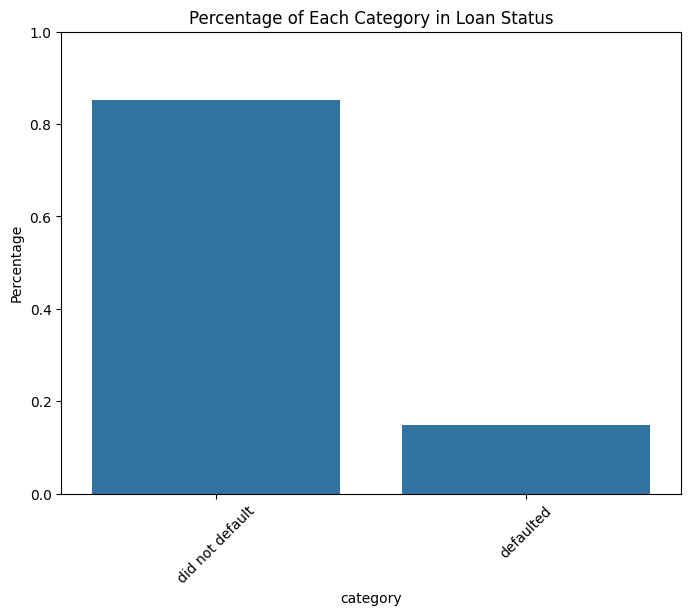

In [63]:
# Calculate the percentage of each category
percentage_df = clean_df[target_variable].value_counts(normalize=True).reset_index()
percentage_df.columns = ['category', 'percentage']

_viz_name = 'eda/target_distribution.png'
# Create a bar plot of percentages
plt.figure(figsize=(8, 6))
sns.barplot(x='category', y='percentage', data=percentage_df)
plt.ylabel('Percentage')
plt.title('Percentage of Each Category in {}'.format(target_variable))
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 (100%)
plt.xticks(rotation=45)
plt.savefig(_viz_name)

****Observations and insights****
- Distribution of 'Did not default' is ***above 80%***
- Data is imbalanced

****Action item****
- Data has to be balanced to prevent bias towards the `did not default class`

### Numerical variables

In [64]:
# Get numerical columns
numerical_columns_list = get_numerical_columns(X)
numerical_columns_list

['Unnamed: 0',
 'loan_amount',
 'outstanding_balance',
 'interest_rate',
 'age',
 'remaining term',
 'salary']

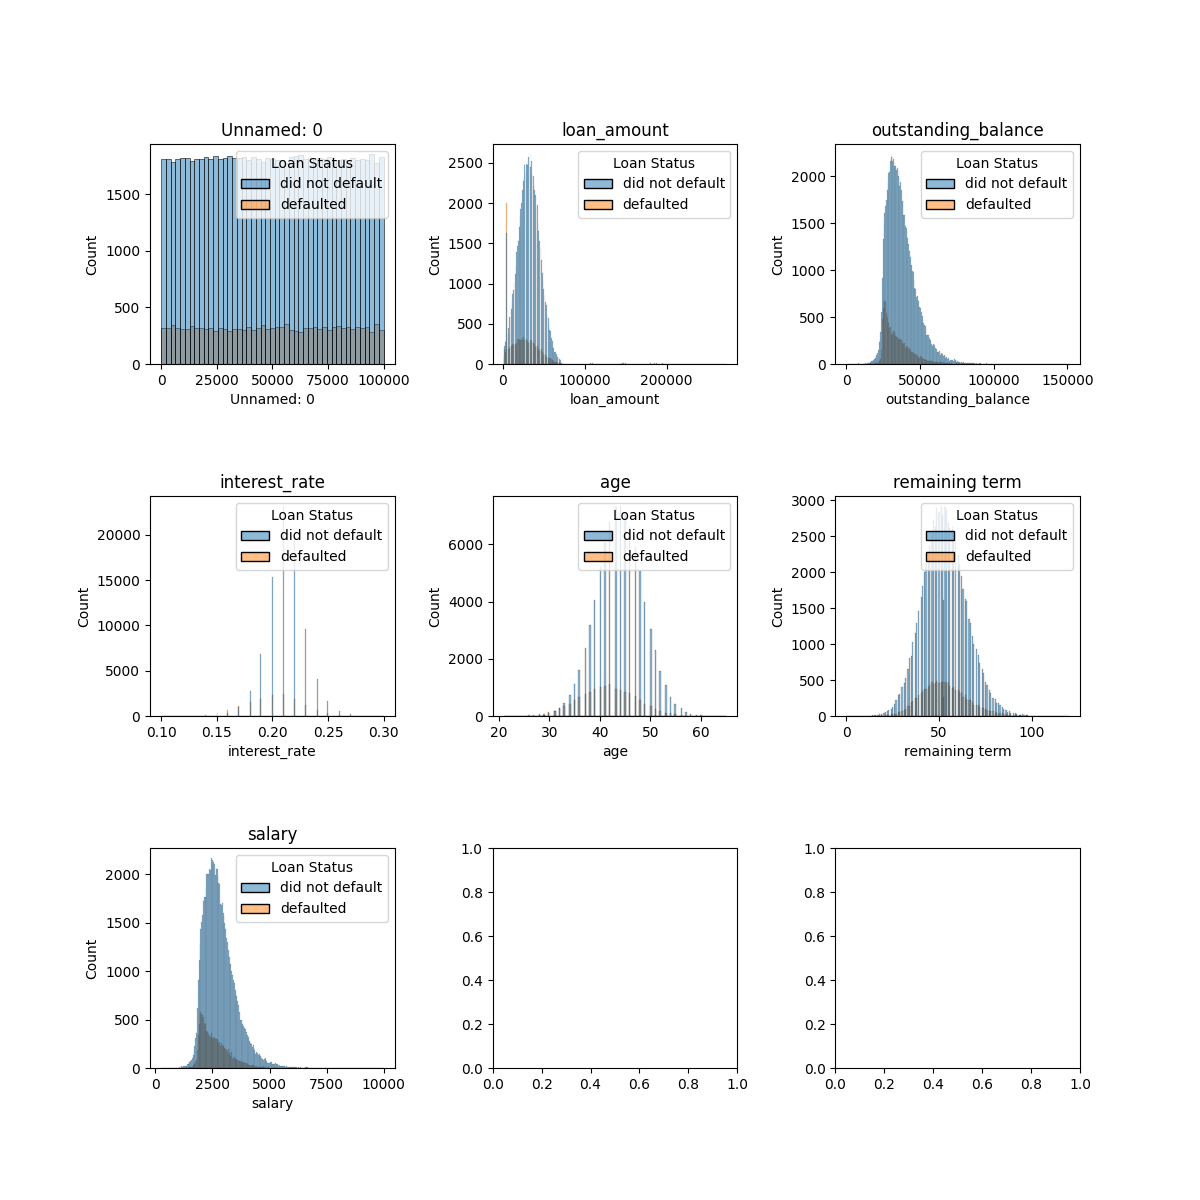

In [65]:
_viz_name = 'eda/numerical_distribution.png'
display_numerical_features_visualization(clean_df, numerical_columns_list, _viz_name)
# Display the image
Image(filename=_viz_name)

****Observations and insights****
- Impact of `Loan status` not very visible on all variables due to class imbalance

- `Unnamed: 0'` is uniformly distributed.
- `loan_amount` is skewed to the right, skewness could be lognormal distribtuion of data (domain knowledeg on loan amount) or which shows presence of outliers.
- `outstanding_balance` is skewed to the right, skewness could be lognormal distribtuion of data (domain knowledeg on outstanding_balance) or which shows presence of outliers.
- `interest_rate` appears normally distributed (domain knowledge/ research confirms that most borrowers appear in the middle).
- `age` appears normally distributed.
- `remaining term` appears normally distributed.
- `salary` is skewed to the right, skewness could be lognormal distribtuion of data (domain knowledeg on salary) or which shows presence of outliers.

****Action item****
- To remove uniformly distributted
- To log transform for skewed columns
- To check for outliers for skewed columns
- To scale features to remove effect of huge absolute scale differences between features

### Text variables

In [66]:
# Getting a list of text columns that are not categorical
text_columns_list = get_text_columns(X, 1)
text_columns_list

['loan_id']

### Categorical variables

In [67]:
# Getting a list of categorical columns
categorical_columns_list = get_categorical_columns(X, 1)
categorical_columns_list

['gender',
 'currency',
 'country',
 'is_employed',
 'job',
 'location',
 'number_of_defaults',
 'marital_status']

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

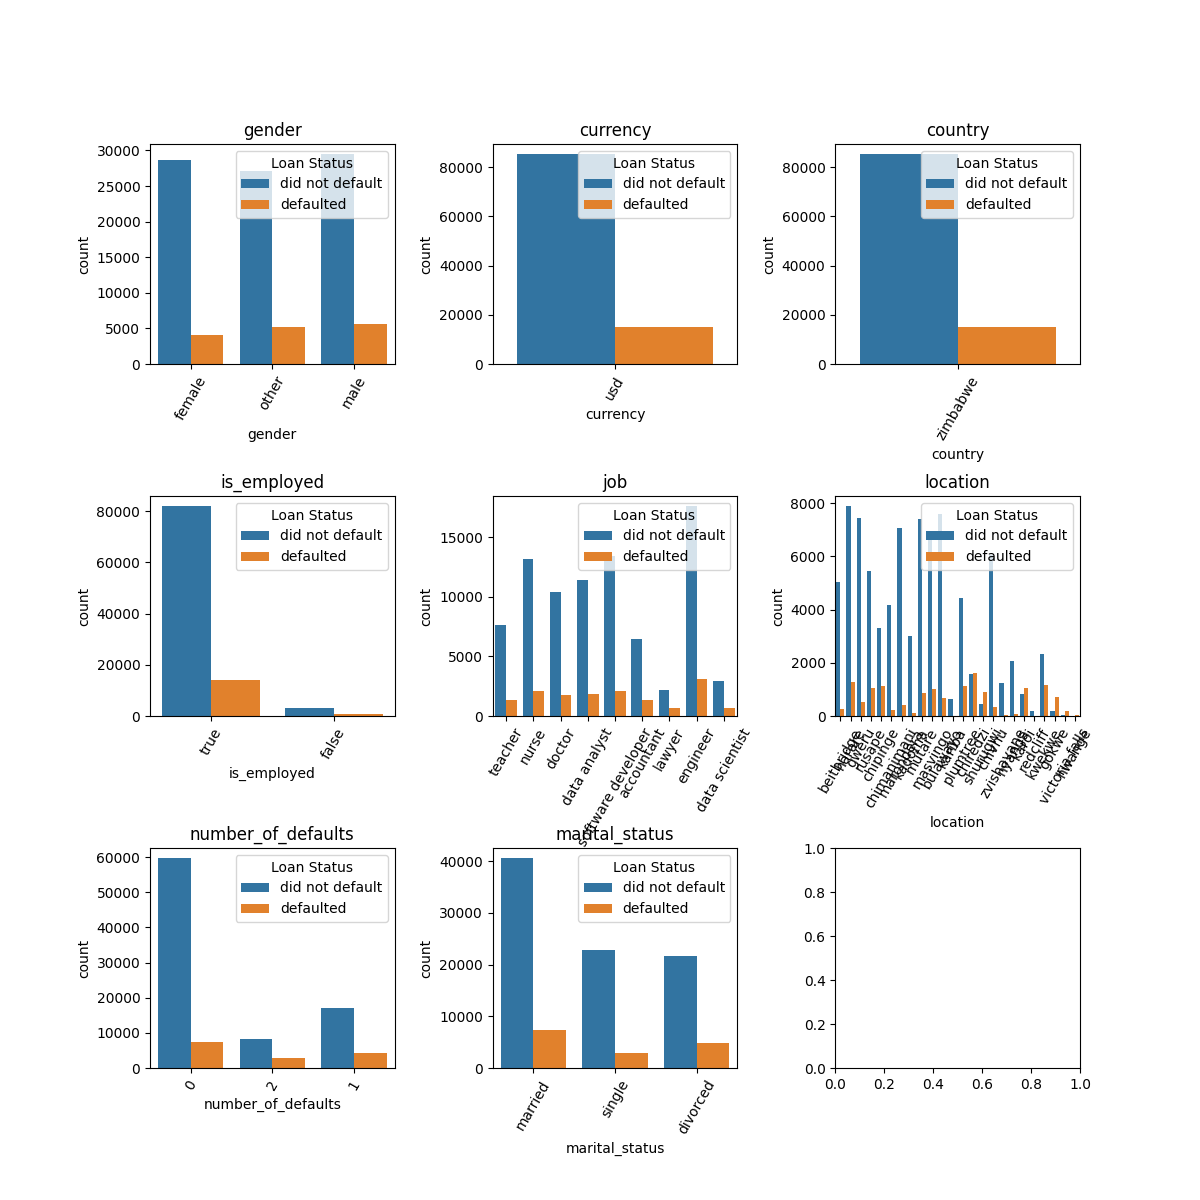

In [68]:
_viz_name = 'eda/categorical_distribution.png'
display_categorical_features_visualization(clean_df, categorical_columns_list, _viz_name)
# Display the image
Image(filename=_viz_name)

****Observations and insights****
- Due to the class imbalance, observations are less conclusive on categorical columns. It's better to visualize only for the defaulted borrowers

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=60)
/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1142297303.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

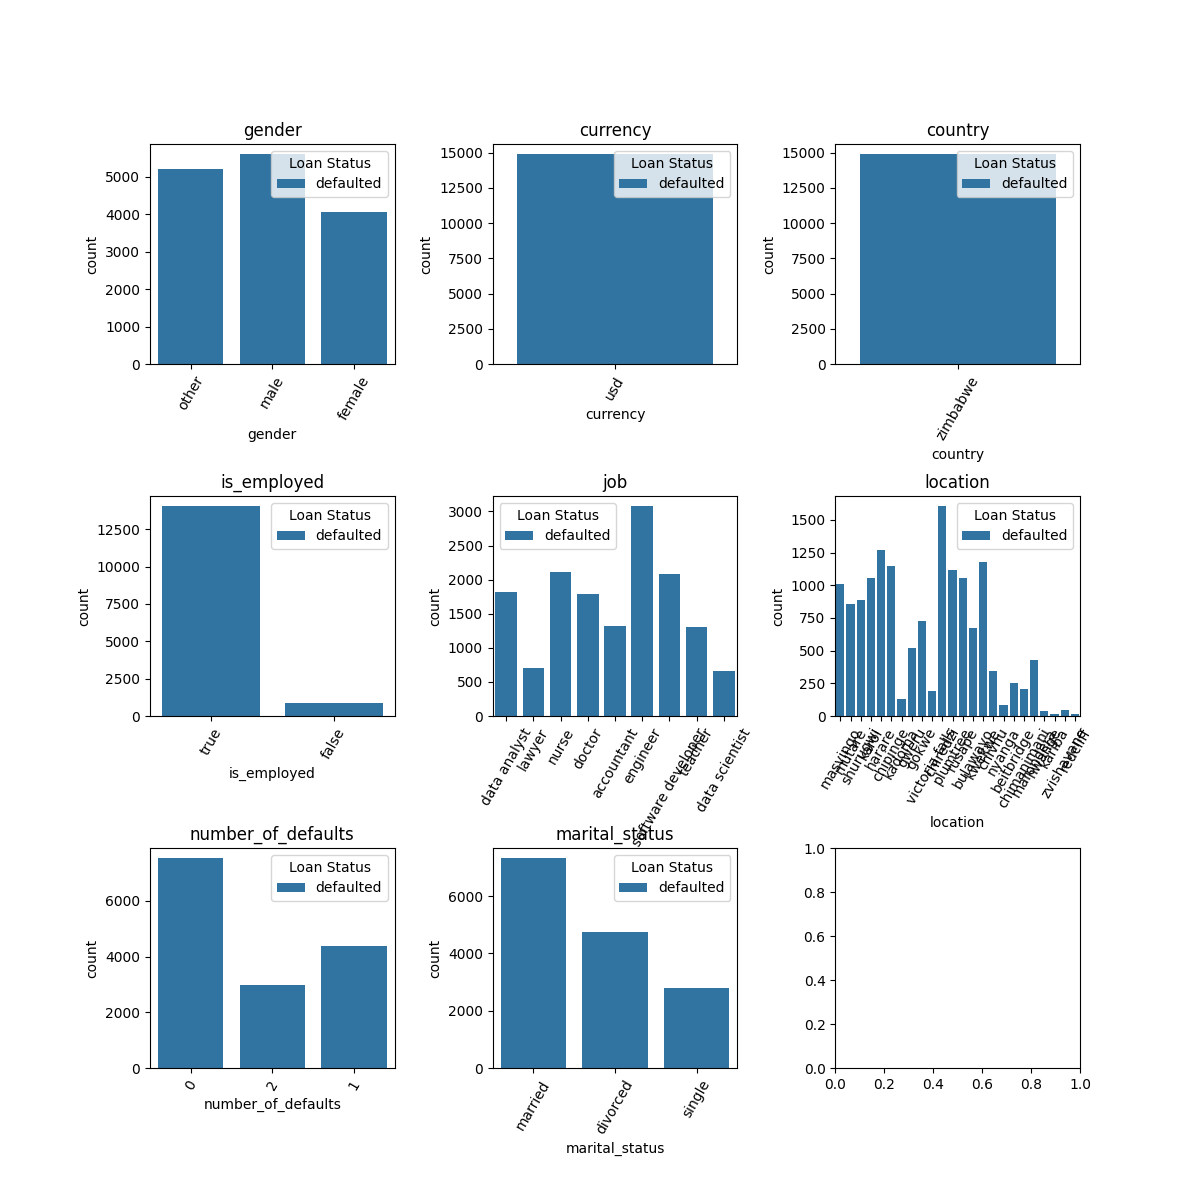

In [69]:
_viz_name = 'eda/categorical_distribution_no_default.png'
default_df = clean_df[clean_df[target_variable] == 'defaulted']
display_categorical_features_visualization(default_df, categorical_columns_list, _viz_name)
# Display the image
Image(filename=_viz_name)

****Observations and insights****
- `gender` appears to be balanced. However Males have a high chance of defaulting
- `is_employed` is visually imbalanced. Employed borrower have more chances of defaulting than the unemployed. One of the causes is that lenders are likely to lend to the employed class, hence the distribution is inheriting data distribution
- `accountants' seems to have higher chances of default. `data analysts` and `data scientist` show low default chances.
- *Interesting pattern* is that chances of default decrease as the `number_of_defaults` increase.
- `marital_status` also has an impact on default. married category shows high chances of default, follwed by divorced and lastly the single class

****Action Items****
- To encode features into data types readable in algorithms

### Date or time variables

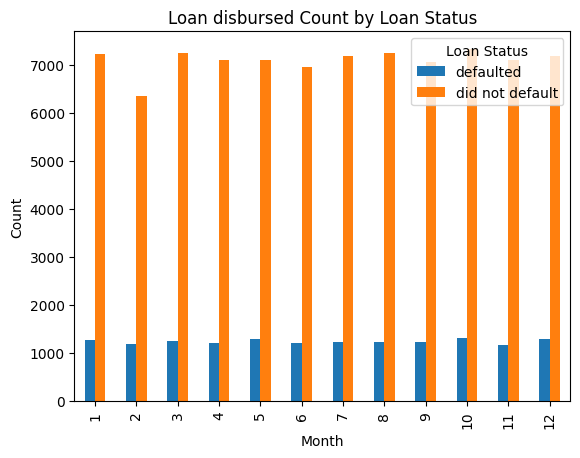

In [70]:
counts = clean_df.groupby([DatetimeIndex(clean_df['disbursemet_date']).month, target_variable])['disbursemet_date'].count()
counts.unstack(fill_value=0).plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Loan disbursed Count by Loan Status')
_viz_name = 'eda/date_distribution.png'
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

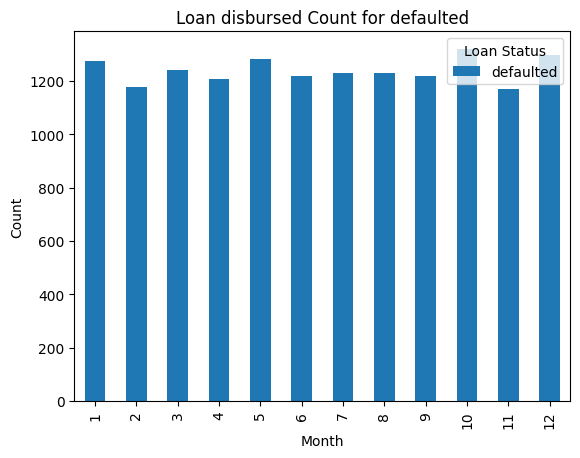

In [71]:
counts = default_df.groupby([DatetimeIndex(default_df['disbursemet_date']).month, target_variable])['disbursemet_date'].count()
counts.unstack(fill_value=0).plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Loan disbursed Count for defaulted')
_viz_name = 'eda/date_distribution_defaulted.png'
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

****Observations and insights****
- `month of disbursement` appears uniform

## Correlations

In [72]:
# Encode the target_variable
target_variable_mapping = {'defaulted': 1, 'did not default': 0}

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1276766254.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  correlation_df[target_variable] = correlation_df[target_variable].replace(target_variable_mapping)


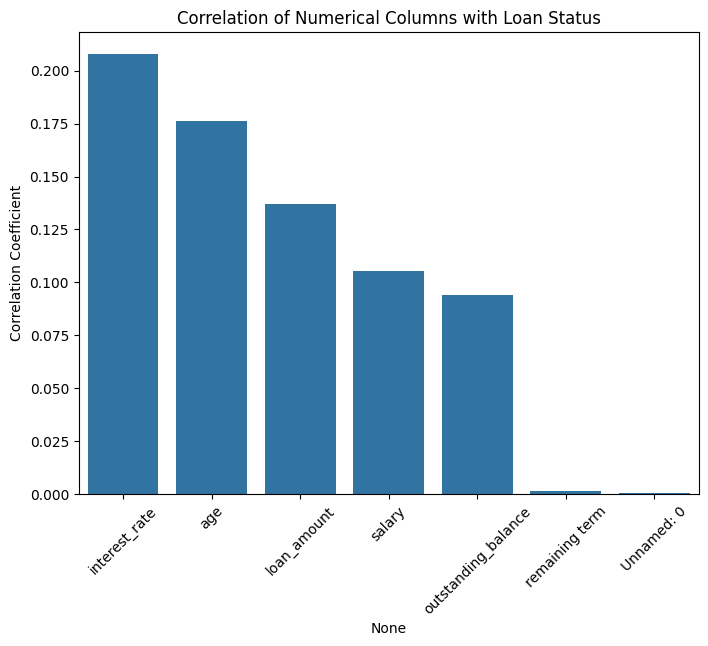

In [73]:
correlation_df = clean_df.copy()
correlation_df[target_variable] = correlation_df[target_variable].replace(target_variable_mapping)

# Calculate correlation with the target variable
correlation = correlation_df[numerical_columns_list + [target_variable]].corr()[target_variable].drop(target_variable)

# Sort correlations in descending order
sorted_correlation = correlation.abs().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values)
plt.ylabel('Correlation Coefficient')
plt.title('Correlation of Numerical Columns with {}'.format(target_variable))
plt.xticks(rotation=45)

_viz_name = 'eda/target_vs_numerical_correaltions.png'
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

****Observations and insights****
- `remaining_term` and `Unnamed: -` have no relationship with the `Loan Status`

****Action Item****
- Remove features with no relationship to let machine learning models work on less features

# Feature engineering

- 🛠️ Removing redundant features
- 🛠️ Removing high cardinality features
- 🛠️ Feature scaling for numerical features with high range scales
- 🛠️ Feature binning for numerical features with defined ranges
- 🛠️ Feature encoding for categorical and binned features

## Section helper methods

### Investigation methods

In [74]:
def get_high_cardinality_columns(_df: DataFrame, category_perc_threshold: float) -> list:
    _df_rows = _df.shape[0]
    max_unique_values = (category_perc_threshold / 100) * _df_rows
    high_cardinality_cols:list = list()

    # Iterate through all columns
    _categorical_cols: list = list()
    for col in _df.columns:

        # When type is object
        column_dtype = _df[col].dtype
        if column_dtype == 'object':
            unique_values = _df[col].nunique()

            # When unique values are at most the threshold
            if unique_values <= max_unique_values:
                _categorical_cols.append(col)

        # When type is categorical
        if isinstance(column_dtype, CategoricalDtype):
            _categorical_cols.append(col)

    return _categorical_cols

### Engineering methods

In [75]:
def bin_data_with_outliers(_df: DataFrame, column_name: str, _bin_details: dict) -> DataFrame:
    # Unpack variables
    min_category_cap = _bin_details.get('min_category_cap')
    max_category_cap = _bin_details.get('max_category_cap')
    num_bins = _bin_details.get('num_bins')
    
    # Compute the bin edges
    bins = linspace(min_category_cap, max_category_cap, num_bins - 1)

    # Ensure max_category_cap is not duplicated in the bins
    if max_category_cap not in bins:
        bins = concatenate((bins, [max_category_cap]))
    else:
        bins = bins.tolist()
        bins[-1] = max_category_cap

    edges = [-np_inf] + list(bins) + [np_inf]

    # Generate bin labels
    bin_labels = []
    for i in range(len(edges) - 1):
        if i == 0:
            bin_label = "below {}".format(edges[i+1]).replace(" ", "_")
        elif i == len(edges) - 2:
            bin_label = "above {}".format(edges[i]).replace(" ", "_")
        else:
            bin_label = "{} to {}".format(edges[i], edges[i+1]).replace(" ", "_")
        bin_labels.append(bin_label)

    # Bin the data, including outliers in the first and last bins
    binned_data = cut(_df[column_name], bins=edges, labels=bin_labels, include_lowest=True)

    # Add the binned data as a new column
    binned_column_name = "binned_{}".format(column_name)
    _df[binned_column_name] = binned_data

    return _df

In [76]:
def log_transform_columns(_df: DataFrame, _columns_list_original: list, _columns_list_transformed: list) -> DataFrame:
    _df[_columns_list_transformed] = _df[_columns_list_original].applymap(lambda x: log(x + 1))
    return _df

In [77]:
def winsorize_columns(_df: DataFrame, _columns_list: list, outlier_threshold: tuple) -> DataFrame:
    for _column in _columns_list:
        _df[_column] = winsorize(_df[_column], outlier_threshold)

    return _df

In [78]:
def normalize_by_standard_scaling(_df: DataFrame, _columns_list: list) -> DataFrame:
    scaler = StandardScaler()
    _df[_columns_list] = scaler.fit_transform(_df[_columns_list])

    return _df

In [79]:
def one_hot_encode_columns(_df: DataFrame, _columns_list: list) -> DataFrame:
    print('Original dimensions are {}'.format(_df.shape))
    
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(handle_unknown='ignore')
    
    # Fit and transform the categorical columns
    encoded_columns = encoder.fit_transform(_df[_columns_list])
    
    # Create a DataFrame from the one-hot encoded columns
    column_names = encoder.get_feature_names_out(_columns_list)
    
    # Convert to dense array if it's sparse
    if hasattr(encoded_columns, 'toarray'):
        encoded_columns = encoded_columns.toarray()
    
    encoded_df = DataFrame(encoded_columns, columns=column_names, index=_df.index)
    print('Encoded columns have {} dimensions'.format(encoded_df.shape))
    
    # Concatenate the one-hot encoded columns with the original DataFrame
    print('Removing {} existing columns'.format(len(_columns_list)))
    
    _df = concat([_df.drop(columns=_columns_list), encoded_df], axis=1)
    print('Merged columns have {} dimensions'.format(_df.shape))
    
    return _df

## Feature engineering process

In [80]:
X_features = X.copy()

In [81]:
X_features.head()

,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022-10-29,usd,zimbabwe,true,teacher,beitbridge,39000.0,0,48653.011473,0.22,37,47.0,3230.038869,married
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020-06-06,usd,zimbabwe,true,teacher,harare,27000.0,2,28752.062237,0.20,43,62.0,3194.139103,single
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023-09-29,usd,zimbabwe,true,nurse,gweru,35000.0,1,44797.554126,0.22,43,57.0,3330.826656,married
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022-06-22,usd,zimbabwe,true,doctor,rusape,24000.0,0,35681.496413,0.23,47,42.0,2246.797020,divorced
4,4,477cd8a1-3b01-4623-9318-8cd6122a8346,male,2023-02-08,usd,zimbabwe,true,nurse,chipinge,19000.0,0,34156.055882,0.20,42,45.0,2310.858441,married


In [82]:
X_features.shape

(100000, 17)

### Redundant features
- Proof by redundancy EDA
- Features with uniform distributions

In [83]:
# Features whose presence or absence does not impact the target variable, but may increase model workload
redundant_features_list = ['currency', 'country', 'disbursemet_date']
X_features = drop_dataframe_columns(X_features, redundant_features_list)

# Add transformation step
trans_module.add_transformation(drop_dataframe_columns, drop_column_list=redundant_features_list)
X_features.shape

(100000, 14)

### High cardinality features
- Proof by unique value count being close or equal to dataset records

In [84]:
high_cardinality_features_list = ['Unnamed: 0', 'loan_id', 'remaining term']
X_features = drop_dataframe_columns(X_features, high_cardinality_features_list)

# Add transformation step
trans_module.add_transformation(drop_dataframe_columns, drop_column_list=high_cardinality_features_list)
X_features.shape

(100000, 11)

### Feature scaling for numerical features

In [85]:
numerical_columns_list = get_numerical_columns(X_features)
numerical_columns_list

['loan_amount', 'outstanding_balance', 'interest_rate', 'age', 'salary']

#### Outlier detection visual method

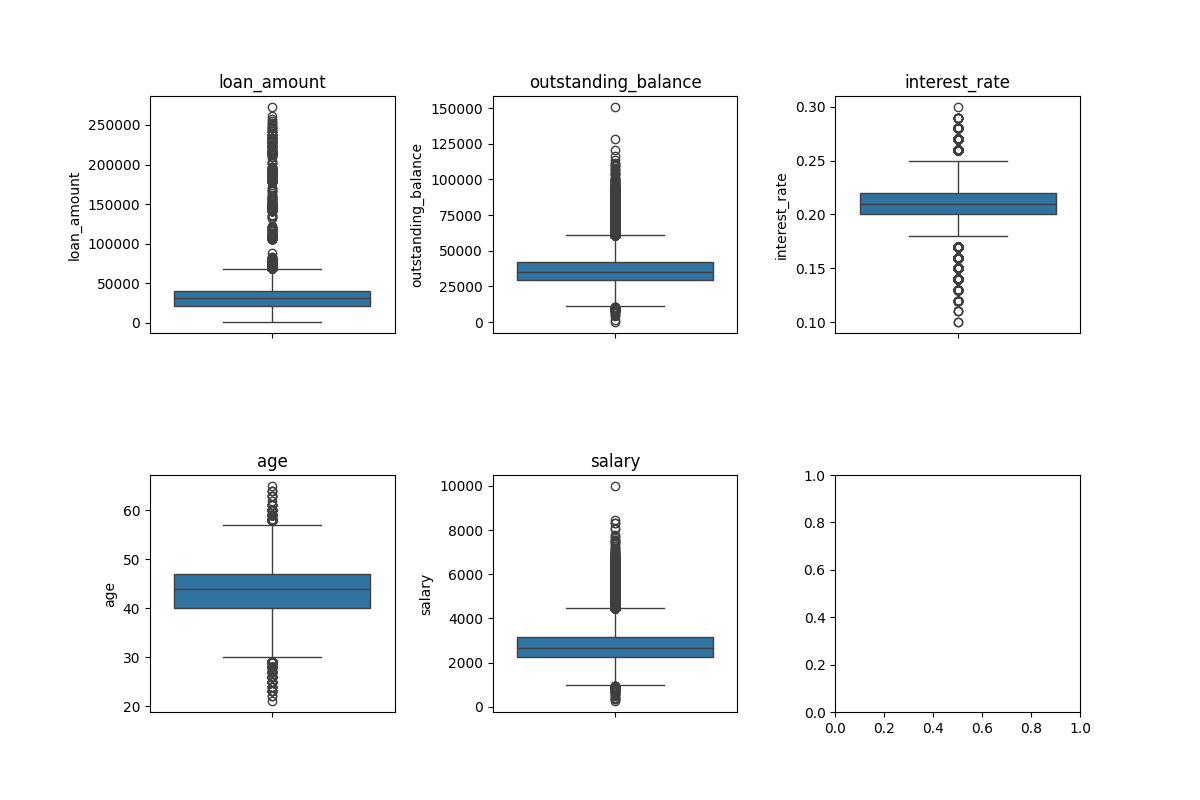

In [86]:
_viz_name = 'eda/outlier.png'
display_boxplot_visualization(X_features, numerical_columns_list, _viz_name)
# Display the image
Image(filename=_viz_name)

#### Outlier detection statistical method

In [87]:
number_of_rows = X_features.shape[0]
outliers_list_details: list = list()
for numerical_column in numerical_columns_list:
    # Calculate Z-scores
    z_scores = stats.zscore(X_features[numerical_column])
    outliers_upper = X_features[numerical_column][z_scores > 3]
    outliers_lower = X_features[numerical_column][z_scores < -3]

    # Find the value corresponding to z = 3
    value_at_z3 = quantile(X_features[numerical_column], stats.norm.cdf(3))

    # Find the value corresponding to z = -3
    value_at_nz3 = quantile(X_features[numerical_column], stats.norm.cdf(-3))

    outlier_results = {
        'column': numerical_column,
        'lower_outliers_count': outliers_lower.count(),
        'upper_outliers_count': outliers_upper.count(),
        'min_value': min(X_features[numerical_column]),
        'max_value': max(X_features[numerical_column]),
        'lower_value_limit': value_at_nz3,
        'upper_value_limit': value_at_z3
    }
    outliers_list_details.append(outlier_results)

outliers_details_df = DataFrame(outliers_list_details)
outliers_details_df

,column,lower_outliers_count,upper_outliers_count,min_value,max_value,lower_value_limit,upper_value_limit
0,loan_amount,0,305,1000.0,273000.0,1000.000000,180000.000000
1,outstanding_balance,6,1232,0.0,150960.0,16626.389640,84937.245045
2,interest_rate,722,299,0.1,0.3,0.140000,0.270000
3,age,173,94,21.0,65.0,28.000000,58.000000
4,salary,14,1194,250.0,10000.0,1299.227094,6087.865786


In [88]:
transform_to_log_columns_list = ['loan_amount', 'outstanding_balance', 'salary']
transform_to_log_binned_columns_list = ['interest_rate', 'age']

#### Log transformation for skewed features

In [89]:
transformed_log_columns_list = ['log_{}'.format(column) for column in transform_to_log_columns_list]
transformed_log_columns_list

['log_loan_amount', 'log_outstanding_balance', 'log_salary']

In [90]:
X_features = log_transform_columns(X_features, transform_to_log_columns_list, transformed_log_columns_list)

# Add transformation step
trans_module.add_transformation(log_transform_columns, _columns_list_original=transform_to_log_columns_list, _columns_list_transformed=transformed_log_columns_list)
X_features.shape

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/2875547396.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df[_columns_list_transformed] = _df[_columns_list_original].applymap(lambda x: log(x + 1))


(100000, 14)

#### Feature winsorization

In [91]:
X_features = winsorize_columns(X_features, transformed_log_columns_list, (0.05, 0.05))

# Add transformation step
trans_module.add_transformation(winsorize_columns, _columns_list=transformed_log_columns_list, outlier_threshold=(0.05, 0.05))
X_features.shape

(100000, 14)

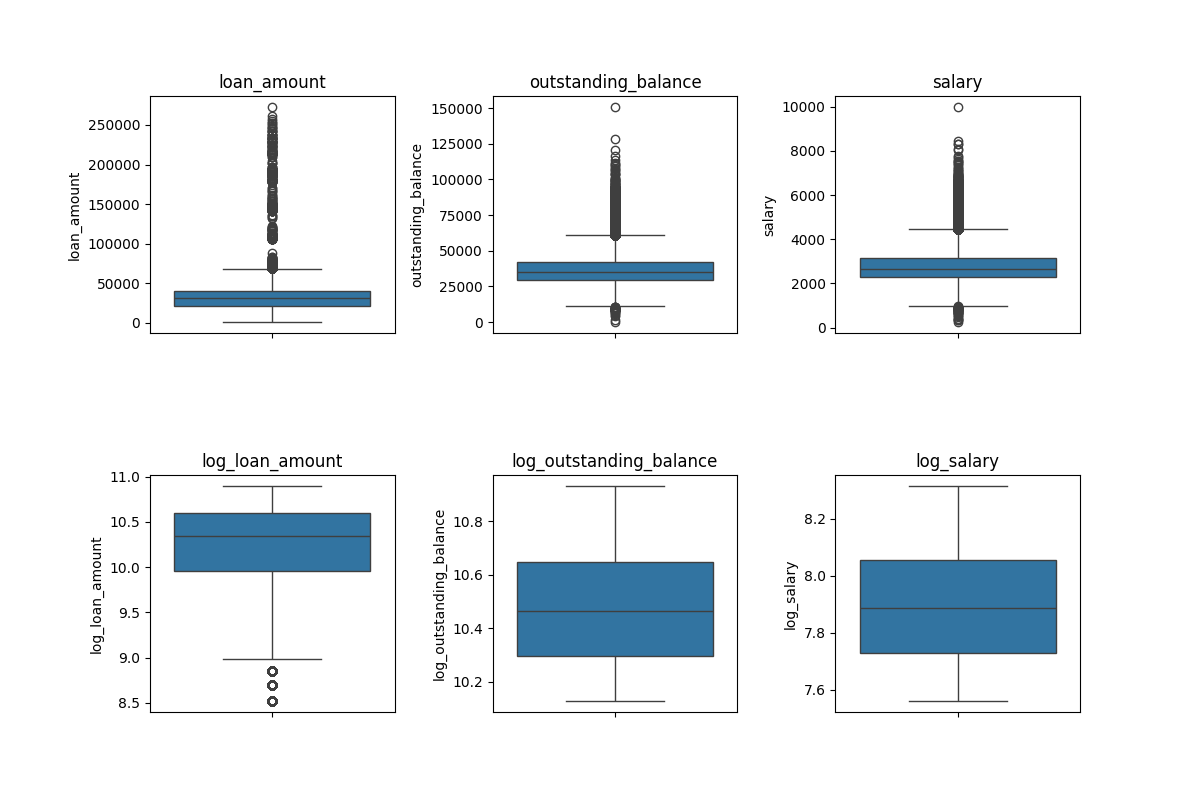

In [92]:
before_and_after_columns_list = transform_to_log_columns_list + transformed_log_columns_list
_viz_name = 'eda/outlier_before_and_after_log_and_winsorization.png'
display_boxplot_visualization(X_features, before_and_after_columns_list, _viz_name)
# Display the image
Image(filename=_viz_name)

In [93]:
X_features = drop_dataframe_columns(X_features, transform_to_log_columns_list)

# Add transformation step
trans_module.add_transformation(drop_dataframe_columns, drop_column_list=transform_to_log_columns_list)
X_features.shape

(100000, 11)

#### Normalize scaling

In [94]:
X_features = normalize_by_standard_scaling(X_features, transformed_log_columns_list)

# Add transformation step
trans_module.add_transformation(normalize_by_standard_scaling, _columns_list=transformed_log_columns_list)
X_features.shape

(100000, 11)

### Feature binning for numerical features

In [95]:
transform_to_log_binned_columns_list

['interest_rate', 'age']

In [96]:
# Assuming you have a dataframe 'df' and a list of names 'name_list'
outliers_details_df_binning_columns = outliers_details_df[outliers_details_df['column'].isin(transform_to_log_binned_columns_list)]
outliers_details_df_binning_columns

,column,lower_outliers_count,upper_outliers_count,min_value,max_value,lower_value_limit,upper_value_limit
2,interest_rate,722,299,0.1,0.3,0.14,0.27
3,age,173,94,21.0,65.0,28.00,58.00


In [97]:
_binning_column = 'interest_rate'
bin_details = {'num_bins': 6, 'min_category_cap': 0.15, 'max_category_cap': 0.25}
X_features = bin_data_with_outliers(X_features, _binning_column, bin_details)

# Add transformation step
trans_module.add_transformation(bin_data_with_outliers, column_name=_binning_column, _bin_details=bin_details)

# Display results
bin_stats = X_features.groupby('binned_{}'.format(_binning_column))[_binning_column].agg(['min', 'max', 'count']).reset_index()
print(X_features.shape, '\n____________')
bin_stats

(100000, 12) 
____________


/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/928545604.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = X_features.groupby('binned_{}'.format(_binning_column))[_binning_column].agg(['min', 'max', 'count']).reset_index()


,binned_interest_rate,min,max,count
0,below_0.15,0.10,0.15,722
1,0.15_to_0.175,0.16,0.17,3143
2,0.175_to_0.2,0.18,0.20,30649
3,0.2_to_0.225,0.21,0.22,46926
4,0.225_to_0.25,0.23,0.25,17544
5,above_0.25,0.26,0.30,1016


In [98]:
_binning_column = 'age'
bin_details = {'num_bins': 9, 'min_category_cap': 25, 'max_category_cap': 60}
X_features = bin_data_with_outliers(X_features, _binning_column, bin_details)

# Add transformation step
trans_module.add_transformation(bin_data_with_outliers, column_name=_binning_column, _bin_details=bin_details)

# Display results
bin_stats = X_features.groupby('binned_{}'.format(_binning_column))[_binning_column].agg(['min', 'max', 'count']).reset_index()
print(X_features.shape, '\n____________')
bin_stats

(100000, 13) 
____________


/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/3692688007.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = X_features.groupby('binned_{}'.format(_binning_column))[_binning_column].agg(['min', 'max', 'count']).reset_index()


,binned_age,min,max,count
0,below_25.0,21,25,25
1,25.0_to_30.0,26,30,521
2,30.0_to_35.0,31,35,4550
3,35.0_to_40.0,36,40,20649
4,40.0_to_45.0,41,45,39395
5,45.0_to_50.0,46,50,27465
6,50.0_to_55.0,51,55,6763
7,55.0_to_60,56,60,616
8,above_60,61,65,16


In [99]:
X_features = drop_dataframe_columns(X_features, transform_to_log_binned_columns_list)

# Add transformation step
trans_module.add_transformation(drop_dataframe_columns, drop_column_list=transform_to_log_binned_columns_list)
X_features.shape

(100000, 11)

### Feature encoding for categorical features

In [100]:
# Encode the Y feature
target_variable_mapping = {'defaulted': 1, 'did not default': 0}
y = Y.replace(target_variable_mapping)
y.value_counts()

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/1245925256.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = Y.replace(target_variable_mapping)


Loan Status
0    85134
1    14866
Name: count, dtype: int64

In [101]:
categorical_columns_list = get_categorical_columns(X_features, 1)
categorical_columns_list

['gender',
 'is_employed',
 'job',
 'location',
 'number_of_defaults',
 'marital_status',
 'binned_interest_rate',
 'binned_age']

In [102]:
X_features = one_hot_encode_columns(X_features, categorical_columns_list)

# Add transformation step
trans_module.add_transformation(one_hot_encode_columns, _columns_list=categorical_columns_list)
X_features.shape

Original dimensions are (100000, 11)
Encoded columns have (100000, 59) dimensions
Removing 8 existing columns
Merged columns have (100000, 62) dimensions


(100000, 62)

In [103]:
X_features.dtypes

log_loan_amount            float64
log_outstanding_balance    float64
log_salary                 float64
gender_female              float64
gender_male                float64
                            ...   
binned_age_45.0_to_50.0    float64
binned_age_50.0_to_55.0    float64
binned_age_55.0_to_60      float64
binned_age_above_60        float64
binned_age_below_25.0      float64
Length: 62, dtype: object

# Data transformation summary

- Identification and exploring suitable data transformation techniques
- Evaluating the impact of different transformations on model performance
- Storing the selected transformations for consistent application
- Preperation of the dataset, including handling missing values, encoding features, and scaling
- Dividing the dataset to assess the model's performance on unseen data
- Addressing class imbalance issues using appropriate balancing techniques

### Section helper methods

In [104]:
def dataset_similarity_report(_df1: DataFrame, _df2: DataFrame):
    # Column test
    df1_columns = _df1.columns.to_list()
    df2_columns = _df2.columns.to_list()

    # When column names are identical
    if df1_columns == df2_columns:
        print('Dataset columns identical')

        non_identical_columns: list = list()
        for _column in df1_columns:

            # When row items are identical
            identity_check = _df1[_column].to_list() == _df2[_column].to_list()
            if not identity_check:
                non_identical_columns.append(_column)

        # When columns with unidentical rows have been identified
        if non_identical_columns:
            print(non_identical_columns, ': are not row identical')

        # When all records are identical
        else:
            print('All records for each column are identical')
    
    # When columns names do not match
    else:
        items_in_list1_not_in_list2 = set(df1_columns) - set(df2_columns)
        items_in_list2_not_in_list1 = set(df2_columns) - set(df1_columns)
        print("Columns in dataset 1 that are not in dataset 2:", items_in_list1_not_in_list2)
        print("Columns in dataset 2 that are not in dataset 1:", items_in_list2_not_in_list1)

In [105]:
def save_transformations(transformation_module, _module_name: str='loan_data_transformation'):
    # Check for any transformations in directory
    module_list = listdir(TRANSFORMATIONS_DIR)

    # When module list exists
    check_name_count: int = 0
    if module_list:
        check_name_list = [module_name_ for module_name_ in module_list if _module_name in module_name_]
        check_name_count = len(check_name_list)

    # Indicate the nth of the coming report
    check_name_count += 1
    module_file_name = '{}/{}_{}.pkl'.format(TRANSFORMATIONS_DIR, _module_name, check_name_count)
    
    # Save the TransformationModule object
    with open(module_file_name, 'wb') as f:
        dill.dump(transformation_module, f)

    # When report has been generated
    if exists(module_file_name):
        print('Module: {} successfully saved!'.format(module_file_name))

    else:
        print('No generated module!')

### Check transformations

In [106]:
_i = 1
for _transformation in trans_module.transformations:
    transformation_function = _transformation[0]
    print('\nStep {}:'.format(_i))
    print(transformation_function.__name__, _transformation[2])
    _i += 1


Step 1:
drop_dataframe_columns {'drop_column_list': ['sex', 'number_of_defaults.1', 'age.1']}

Step 2:
convert_from_text_to_date {'_columns_list': ['disbursemet_date']}

Step 3:
convert_from_text_to_numeric {'_columns_list': ['remaining term']}

Step 4:
convert_to_text {'_columns_list': ['is_employed', 'number_of_defaults']}

Step 5:
replace_empty_or_blank_values {}

Step 6:
treat_missing_by_mode_imputation {'_columns_list': ['country', 'job', 'location', 'marital_status']}

Step 7:
treat_missing_by_mean_imputation {'_columns_list': ['remaining term']}

Step 8:
clean_text_columns {'column_names': ['loan_id', 'gender', 'currency', 'country', 'is_employed', 'job', 'location', 'number_of_defaults', 'marital_status']}

Step 9:
make_value_corrections {'instructions': [{'column': 'currency', 'value': 'usd', 'to correct': ['$usd', 'usd']}, {'column': 'country', 'value': 'zimbabwe', 'to correct': ['zim', 'zimbabwe']}, {'column': 'job', 'value': 'software developer', 'to correct': ['softwarede

### Test transformations

In [107]:
transformation_test_df = raw_X.copy()
transformation_test_df.shape

(100000, 20)

In [108]:
df_transformed = trans_module.apply_transformations(transformation_test_df)


Applying transformation: drop_dataframe_columns
Before transformation: (100000, 20)
After transformation: (100000, 17)

Applying transformation: convert_from_text_to_date
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: convert_from_text_to_numeric
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: convert_to_text
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: replace_empty_or_blank_values
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: treat_missing_by_mode_imputation
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: treat_missing_by_mean_imputation
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying transformation: clean_text_columns
Before transformation: (100000, 17)
After transformation: (100000, 17)

Applying trans

/var/folders/0_/dstxztpd6r98_5jbgn2kmbpm0000gn/T/ipykernel_42513/2875547396.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df[_columns_list_transformed] = _df[_columns_list_original].applymap(lambda x: log(x + 1))


After transformation: (100000, 14)

Applying transformation: winsorize_columns
Before transformation: (100000, 14)
After transformation: (100000, 14)

Applying transformation: drop_dataframe_columns
Before transformation: (100000, 14)
After transformation: (100000, 11)

Applying transformation: normalize_by_standard_scaling
Before transformation: (100000, 11)
After transformation: (100000, 11)

Applying transformation: bin_data_with_outliers
Before transformation: (100000, 11)
After transformation: (100000, 12)

Applying transformation: bin_data_with_outliers
Before transformation: (100000, 12)
After transformation: (100000, 13)

Applying transformation: drop_dataframe_columns
Before transformation: (100000, 13)
After transformation: (100000, 11)

Applying transformation: one_hot_encode_columns
Before transformation: (100000, 11)
Original dimensions are (100000, 11)
Encoded columns have (100000, 59) dimensions
Removing 8 existing columns
Merged columns have (100000, 62) dimensions
Afte

In [109]:
dataset_similarity_report(X_features, df_transformed)

Dataset columns identical
All records for each column are identical


### Save transformations for inference

In [110]:
save_transformations(trans_module)

Module: transformations/loan_data_transformation_2.pkl successfully saved!


# Data pre-processing

### Split to train and test

In [111]:
# Split the data into train and test sets
X_feature_train, X_test, y_feature_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

In [112]:
print('X_feature_train: ', X_feature_train.shape, '; y_feature_train: ', y_feature_train.shape)
print('X_test: ', X_test.shape, '; y_test: ', y_test.shape)

X_feature_train:  (70000, 62) ; y_feature_train:  (70000,)
X_test:  (30000, 62) ; y_test:  (30000,)


In [113]:
print('Original training set class distribution:', Counter(y_feature_train))

Original training set class distribution: Counter({0: 59530, 1: 10470})


### Apply Balancing technique

In [114]:
# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_feature_train, y_feature_train)
print('X_train: ', X_train.shape,' ; y_train: ', y_train.shape)

X_train:  (119060, 62)  ; y_train:  (119060,)


In [115]:
# Check the class distribution in the resampled training set
print('Resampled training set class distribution:', Counter(y_train))

Resampled training set class distribution: Counter({0: 59530, 1: 59530})


# Model building

- Choosing an appropriate classification algorithm and configure its initial settings
- Optimizing the model's hyperparameters through a systematic process of cross-validation

## Section helper methods

In [116]:
def compile_cv_results(desired_run_id: int):
    # Initialize an empty list to store the results
    _cv_results: list = list()
    _best_params_dict: dict = dict()
    # Iterate through the files in the directory
    for filename in listdir(CROSS_VALIDATION_DIR):
        if filename.endswith('.pkl'):
            # Extract the run_id and setup_name from the filename
            _file_details = filename.split('_')
            _run_id, _setup_name = _file_details[0], _file_details[1]
            _run_id = int(_run_id)
    
            # Check if the run_id matches the one you're interested in
            if _run_id == desired_run_id:
                # Load the pickled data
                with open('{}/{}'.format(CROSS_VALIDATION_DIR, filename), 'rb') as f:
                    _data = pickle.load(f)
                f.close()
    
                # Add the results to the list
                _cv_results.append({**_data['result'], 'setup_name': _setup_name})

                # Add params to dict
                _best_params_dict[_setup_name] = _data.get('params')

    # Create the DataFrame
    _cv_results_df = DataFrame(_cv_results)

    return _cv_results_df, _best_params_dict

The weights in the scoring function (0.3 for ROC AUC, 0.2 each for precision, recall, and F1, and 0.1 for accuracy) are chosen to prioritize ROC AUC while giving equal importance to precision, recall, and F1, and slightly less importance to accuracy.

In [117]:
def score_model(model):
    return (
        0.3 * model['roc_auc'] +
        0.2 * model['precision'] +
        0.2 * model['recall'] +
        0.2 * model['f1'] +
        0.1 * model['accuracy']
    )

In [118]:
def get_best_models(results_df: DataFrame, n=5) -> DataFrame:
    
    # Calculate the combined score
    results_df['score'] = results_df.apply(score_model, axis=1)
    
    # Sort by score in descending order and select top n
    _best_models_df = results_df.sort_values('score', ascending=False).head(n)
    
    return _best_models_df

## Classification algorithm setup

In [122]:
# Classifier instances
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier(force_row_wise=True)
svc = SVC(probability=True)
knn = KNeighborsClassifier()
gnb = GaussianNB()

In [123]:
# Hyperparameter dictionaries
lr_param_dist = {
    'C': stats.uniform(0.1, 10),
    'penalty': ['l2', 'l1', 'elasticnet'],
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5]
}

lda_param_dist = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(stats.uniform(0, 1).rvs(5))
}

dt_param_dist = {
    'max_depth': stats.randint(3, 20),
    'min_samples_split': stats.randint(2, 11),
    'min_samples_leaf': stats.randint(1, 11)
}

et_param_dist = {
    'n_estimators': stats.randint(50, 300),
    'max_depth': stats.randint(3, 20),
    'min_samples_split': stats.randint(2, 11),
    'min_samples_leaf': stats.randint(1, 11)
}

gbc_param_dist = {
    'n_estimators': stats.randint(50, 300),
    'learning_rate': stats.uniform(0.01, 0.3),
    'max_depth': stats.randint(3, 20)
}

rf_param_dist = {
    'n_estimators': stats.randint(50, 300),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': stats.randint(3, 20),
    'min_samples_split': stats.randint(2, 11),
    'min_samples_leaf': stats.randint(1, 11)
}

xgb_param_dist = {
    'max_depth': stats.randint(3, 20),
    'learning_rate': stats.uniform(0.01, 0.3),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators': stats.randint(50, 300)
}

lgbm_param_dist = {
    'num_leaves': stats.randint(20, 100),
    'learning_rate': stats.uniform(0.01, 0.3),
    'n_estimators': stats.randint(50, 300)
}

svc_param_dist = {
    'C': stats.uniform(0.1, 10),
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto'] + list(stats.uniform(0.01, 1).rvs(3))
}

knn_param_dist = {
    'n_neighbors': stats.randint(3, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gnb_param_dist = {
    'var_smoothing': stats.uniform(1e-10, 1e-8)
}

In [125]:
modelling_setup = [
    {'name': 'xgb', 'classifier': xgb, 'params': xgb_param_dist},
    {'name': 'lgbm', 'classifier': lgbm, 'params': lgbm_param_dist},
    {'name': 'et', 'classifier': et, 'params': et_param_dist},
    {'name': 'dt', 'classifier': dt, 'params': dt_param_dist},
    {'name': 'gnb', 'classifier': gnb, 'params': gnb_param_dist},
    {'name': 'lr', 'classifier': lr, 'params': lr_param_dist},
    {'name': 'lda', 'classifier': lda, 'params': lda_param_dist},
    {'name': 'rf', 'classifier': rf, 'params': rf_param_dist},
    {'name': 'gbc', 'classifier': gbc, 'params': gbc_param_dist},
    {'name': 'knn', 'classifier': knn, 'params': knn_param_dist},
    {'name': 'svc', 'classifier': svc, 'params': svc_param_dist}
]

## Hyper parameter tuning using cross-validation

Why RandomizedSearchCV

1. **Efficiency**: RandomizedSearchCV is generally more efficient than GridSearchCV, especially when dealing with a large number of hyperparameters or a wide range of possible values. Instead of exhaustively searching all possible combinations like GridSearchCV, RandomizedSearchCV samples a fixed number of hyperparameter combinations, which can significantly reduce computation time¹.

2. **Exploration**: By setting `n_iter=10`, you allow RandomizedSearchCV to explore a diverse set of hyperparameter combinations. This can often lead to finding a good set of hyperparameters more quickly than GridSearchCV, which might miss optimal combinations if the grid is not fine enough².

3. **Flexibility**: RandomizedSearchCV can handle both continuous and discrete hyperparameters more effectively. It allows for specifying distributions for hyperparameters, which can be more realistic and practical for certain types of parameters².

4. **Scalability**: Given the constraints of the hackathon (e.g., limited time and computational resources), RandomizedSearchCV is a practical choice. It balances the need for thorough hyperparameter tuning with the necessity of completing the task within a reasonable timeframe¹.

5. **Performance Metric**: By setting `refit='roc_auc'`, you ensure that the model is optimized based on the ROC AUC score, which is a suitable metric for imbalanced datasets like loan default prediction

https://drlee.io/hyperparameter-optimization-grid-search-vs-random-search-vs-bayesian-optimization-in-action-106f99b94e32.
https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/.
ttps://stackoverflow.com/questions/55849512/gridsearchcv-vs-bayesian-optimization.
https://grabngoinfo.com/hyperparameter-tuning-for-xgboost-grid-search-vs-random-search-vs-bayesian-optimization/.

In [126]:
# Define scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Time limit for each model
time_limit = timedelta(minutes=10)

# Run ID represents set of parameters set for the Randomsearch. Files with the different run_ids should not be compared

run_id = 3


for _setup in modelling_setup:
    
    setup_name = _setup['name']
    
    print('\n{}-------------'.format(setup_name))
    _clf = _setup['classifier']
    _param_dist = _setup['params']
    
    start_time = datetime.now()
    
    random_search = RandomizedSearchCV(
        estimator=_clf,
        param_distributions=_param_dist,
        cv=5,  # low number for faster execution
        scoring=scoring,
        n_iter=10,  # high number for better exploration
        refit='roc_auc',
        random_state=5,
        # n_jobs=-1,  # Use all available cores
        verbose=2,
        # return_train_score=True
    )
    
    try:
        # Use a separate thread to run the fit method
        from threading import Thread
        fit_thread = Thread(target=random_search.fit, args=(X_train, y_train))
        fit_thread.start()
        
        # Check if the time limit has been exceeded
        while fit_thread.is_alive():
            if datetime.now() - start_time > time_limit:
                print("\nTime limit exceeded for {}. Moving to next model.".format(setup_name))
                raise TimeoutError
            time.sleep(10)  # Check every 10 seconds
        
        fit_thread.join()
        
    except TimeoutError:
        continue
    except Exception as e:
        print("An error occurred with {}: {}".format(setup_name, str(e)))
        continue
    
    end_time = datetime.now()
    time_taken = (end_time - start_time).total_seconds()
    
    _results = {
        'name': setup_name,
        'roc_auc': random_search.cv_results_['mean_test_roc_auc'][random_search.best_index_],
        'accuracy': random_search.cv_results_['mean_test_accuracy'][random_search.best_index_],
        'precision': random_search.cv_results_['mean_test_precision'][random_search.best_index_],
        'recall': random_search.cv_results_['mean_test_recall'][random_search.best_index_],
        'f1': random_search.cv_results_['mean_test_f1'][random_search.best_index_],
        'time_taken': time_taken
    }
    
    # Pickle best parameters with timestamp
    param_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    param_file_name = '{}/{}_{}_cv_results_{}.pkl'.format(CROSS_VALIDATION_DIR, run_id, setup_name, param_timestamp)
    
    with open(param_file_name, 'wb') as f:
        pickle.dump({'params': random_search.best_params_, 'result': _results}, f)
        
    print(f"Time taken: {time_taken:.2f} seconds")


xgb-------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239, subsample=0.6033595776697132; total time=  11.1s
[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239, subsample=0.6033595776697132; total time=  15.0s
[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239, subsample=0.6033595776697132; total time=  14.9s
[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239, subsample=0.6033595776697132; total time=  15.1s
[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239, subsample=0.6033595776697132; total time=  14.6s
[CV] END learning_rate=0.2855832723813765, max_depth=11, n_estimators=278, subsample=0.8058719314513229; total time=   6.8s
[CV] END learning_rate=0.2855832723813765, max_depth=11, n_estimators=278, subsample=0.8058719314513229; total time=   9.1s
[CV] END learning_rate=0.2855832723813765, max_d

/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/pyt

Time taken: 60.03 seconds

lda-------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.2s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.2s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.2s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.2s
[CV] END .......................shrinkage=None, solver=eigen; total time=   0.2s
[CV] END ........shrinkage=0.09274386268153889, solver=eigen; total time=   0.4s
[CV] END ........shrinkage=0.09274386268153889, solver=eigen; total time=   0.5s
[CV] END ........shrinkage=0.09274386268153889, solver=eigen; total time=   0.5s
[CV] END ........shrinkage=0.09274386268153889, solver=eigen; total time=   0.4s
[CV] END ........shrinkage=0.09274386268153889, solver=eigen; total time=   0.5s
[CV] END ..........shrinkage=0.2228629735721127, solver=lsqr; total time=   0.3s
[CV]

/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/sirben/opt/anaconda3/envs/claxon-hackathon/lib/pyt

Time taken: 20.01 seconds

rf-------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=6, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=194; total time=  48.0s
[CV] END max_depth=6, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=194; total time=  45.9s
[CV] END max_depth=6, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=194; total time=  45.8s
[CV] END max_depth=6, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=194; total time=  45.9s
[CV] END max_depth=6, max_features=None, min_samples_leaf=7, min_samples_split=8, n_estimators=194; total time=  46.2s
[CV] END max_depth=12, max_features=sqrt, min_samples_leaf=5, min_samples_split=9, n_estimators=240; total time=  16.0s
[CV] END max_depth=12, max_features=sqrt, min_samples_leaf=5, min_samples_split=9, n_estimators=240; total time=  15.3s
[CV] END max_depth=12, max_features=sqrt, min_samples_leaf=5,

KeyboardInterrupt: 

In [135]:
random_search_results_df, best_params = compile_cv_results(3)
random_search_results_df

,name,roc_auc,accuracy,precision,recall,f1,time_taken,setup_name
0,gnb,0.829210,0.759365,0.764654,0.759365,0.758161,10.009493,gnb
1,et,0.950059,0.876466,0.884931,0.876466,0.875584,490.236975,et
2,lgbm,0.979759,0.923954,0.948300,0.923954,0.916891,180.087466,lgbm
3,lr,0.847823,0.772736,0.774408,0.772736,0.772389,60.025129,lr
4,dt,0.937258,0.885696,0.894853,0.885696,0.884268,40.023696,dt
5,xgb,0.983866,0.942122,0.954432,0.942122,0.940086,310.143956,xgb
6,et,0.956178,0.885713,0.894029,0.885713,0.884841,630.310288,et
7,lda,0.846585,0.771309,0.773519,0.771309,0.770845,20.008393,lda


In [136]:
best_models_df = get_best_models(random_search_results_df)
best_models_df

,name,roc_auc,accuracy,precision,recall,f1,time_taken,setup_name,score
5,xgb,0.983866,0.942122,0.954432,0.942122,0.940086,310.143956,xgb,0.956700
2,lgbm,0.979759,0.923954,0.948300,0.923954,0.916891,180.087466,lgbm,0.944152
6,et,0.956178,0.885713,0.894029,0.885713,0.884841,630.310288,et,0.908341
4,dt,0.937258,0.885696,0.894853,0.885696,0.884268,40.023696,dt,0.902710
1,et,0.950059,0.876466,0.884931,0.876466,0.875584,490.236975,et,0.900060


In [137]:
best_models_list = best_models_df['name'].values.tolist()
best_models_list

['xgb', 'lgbm', 'et', 'dt', 'et']

# Model evaluation

- Training the model on the training data to learn the underlying patterns
- Evaluating and selecting the best model based on performance metrics and their relative weights
- Presenting the model's performance, insights, and key metrics in a clear and meaningful way

### Section helper methods

In [138]:
# Define a function for early stopping
def early_stopping_callback(estimator, X, y, cv, n_iter_no_change=10, tol=1e-4):
    scores = []
    for i, (train, val) in enumerate(cv.split(X, y)):
        estimator.fit(X.iloc[train], y.iloc[train])
        score = estimator.score(X.iloc[val], y.iloc[val])
        scores.append(score)
        if i >= n_iter_no_change and np.mean(scores[-n_iter_no_change:]) < np.max(scores[:-n_iter_no_change]) + tol:
            break
            
    return estimator

In [139]:
def load_model_fit_metrics(_model_names: list, _fit_id: int) -> DataFrame:
    metrics_list: list = list()
    for model_name in _model_names:
        pickle_file_name = '{}/{}_{}_metrics.pkl'.format(MODEL_FITTING_RESULTS_DIR, _fit_id, model_name)
        with open(pickle_file_name, 'rb') as f:
            metrics = pickle.load(f)
            metrics_list.append(metrics)
        f.close()
    return DataFrame(metrics_list)

### Model fitting

In [140]:
# Iterate through all selected models
fit_id = 0
for model_details in modelling_setup:
    model_name = model_details.get('name')

    if model_name not in best_models_list:
        continue

    print('\n{}-------------'.format(model_name))
    clf_model = model_details.get('classifier')
    model_hyper_parameters = best_params.get(model_name)

    # Set the best parameters for the model
    tuned_model = clf_model.set_params(**model_hyper_parameters)

    # Record the start time
    start_time = time.time()

    # Fit training data to the tuned model with early stopping for tree-based models
    if model_name in ['xgb', 'lgbm']:
        # For tree-based models, try to use early stopping if available
        try:
            tuned_model.fit(X_train, y_train, 
                            eval_set=[(X_test, y_test)],
                            early_stopping_rounds=10,
                            verbose=False)
        except TypeError:
            # If early stopping is not available, fall back to regular fit
            tuned_model.fit(X_train, y_train)
            
    else:
        # For other models, just fit without early stopping
        tuned_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = tuned_model.predict(X_test)
    y_pred_proba = tuned_model.predict_proba(X_test)[:, 1] if hasattr(tuned_model, 'predict_proba') else y_pred

    # Calculate the metrics
    _accuracy = accuracy_score(y_test, y_pred)
    _precision = precision_score(y_test, y_pred)
    _recall = recall_score(y_test, y_pred)
    _f1 = f1_score(y_test, y_pred)
    _auc = roc_auc_score(y_test, y_pred_proba)

    # Calculate the time taken
    _time_taken = time.time() - start_time

    # Store the metrics in a dictionary
    metrics = {
        'model name': model_name,
        'accuracy': _accuracy,
        'precision': _precision,
        'recall': _recall,
        'f1': _f1,
        'roc_auc': _auc,
        'time taken (seconds)': _time_taken
    }

    # Pickle the tuned model
    with open('{}/{}_{}_tuned_model.pkl'.format(MODEL_FITTING_RESULTS_DIR, fit_id, model_name), 'wb') as f:
        pickle.dump(tuned_model, f)

    # Pickle the metrics
    with open('{}/{}_{}_metrics.pkl'.format(MODEL_FITTING_RESULTS_DIR, fit_id, model_name), 'wb') as f:
        pickle.dump(metrics, f)

    print(f"Model {model_name} trained, evaluated, and saved.")


xgb-------------
Model xgb trained, evaluated, and saved.

lgbm-------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 59530, number of negative: 59530
[LightGBM] [Info] Total Bins 14287
[LightGBM] [Info] Number of data points in the train set: 119060, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model lgbm trained, evaluated, and saved.

et-------------
Model et trained, evaluated, and saved.

dt-------------
Model dt trained, evaluated, and saved.


### Model selection

In [141]:
# Step 1: Load pickled results and display as dataframe
model_fit_metrics_df = load_model_fit_metrics(best_models_list, 0)
model_fit_metrics_df

,model name,accuracy,precision,recall,f1,roc_auc,time taken (seconds)
0,xgb,0.921400,0.815480,0.599181,0.690795,0.881559,40.498592
1,lgbm,0.925467,0.834988,0.612375,0.706562,0.892291,17.802986
2,et,0.900833,0.669854,0.637398,0.653223,0.872151,43.131799
3,dt,0.890667,0.641696,0.574841,0.606431,0.825497,1.983772
4,et,0.900833,0.669854,0.637398,0.653223,0.872151,43.131799


In [142]:
# Step 2: Rank models and get the best 2
best_fitted_models = get_best_models(model_fit_metrics_df, 2)
best_fitted_models

,model name,accuracy,precision,recall,f1,roc_auc,time taken (seconds),score
1,lgbm,0.925467,0.834988,0.612375,0.706562,0.892291,17.802986,0.791019
0,xgb,0.921400,0.815480,0.599181,0.690795,0.881559,40.498592,0.777699


In [143]:
top_2_models = best_fitted_models['model name'].values.tolist()
top_2_models

['lgbm', 'xgb']

In [144]:
# Step 3: Test for overfitting and underfitting
def evaluate_model(model, _X_train, _X_test, _y_train, _y_test):
    train_pred = model.predict(_X_train)
    test_pred = model.predict(_X_test)
    train_auc = roc_auc_score(_y_train, model.predict_proba(_X_train)[:, 1])
    test_auc = roc_auc_score(_y_test, model.predict_proba(_X_test)[:, 1])
    return {
        'train_accuracy': accuracy_score(y_train, train_pred),
        'test_accuracy': accuracy_score(y_test, test_pred),
        'train_auc': train_auc,
        'test_auc': test_auc
    }

In [145]:
fit_id = 0
evaluation_results = {}
for model_name in top_2_models:
    pickled_file_name = '{}/{}_{}_tuned_model.pkl'.format(MODEL_FITTING_RESULTS_DIR, fit_id, model_name)
    with open(pickled_file_name, 'rb') as f:
        model = pickle.load(f)
    f.close()
    evaluation_results[model_name] = evaluate_model(model, X_train, X_test, y_train, y_test)

print("\nEvaluation Results:")
DataFrame(evaluation_results).T


Evaluation Results:


,train_accuracy,test_accuracy,train_auc,test_auc
lgbm,0.958802,0.925467,0.989769,0.892291
xgb,0.993104,0.921400,0.999920,0.881559


In [146]:
# Additional: Calculate and display Kolmogorov-Smirnov statistic
def ks_statistic(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    return max(tpr - fpr)

ks_stat = ks_statistic(y_test, y_pred_proba)
print(f"\nKolmogorov-Smirnov statistic: {ks_stat:.4f}")


Kolmogorov-Smirnov statistic: 0.5477


In [147]:
# Select the best model based on smallest gap between train and test AUC
best_model_name = min(evaluation_results, key=lambda x: abs(evaluation_results[x]['train_auc'] - evaluation_results[x]['test_auc']))
print("\nBest model: {}".format(best_model_name))


Best model: lgbm


In [148]:
with open('{}/{}_{}_tuned_model.pkl'.format(MODEL_FITTING_RESULTS_DIR, fit_id, best_model_name), 'rb') as f:
    loan_default_model = pickle.load(f)
f.close()
loan_default_model

LGBMClassifier(force_row_wise=True,
               learning_rate=np.float64(0.07201574660182793), n_estimators=194,
               num_leaves=93)

### Model results display

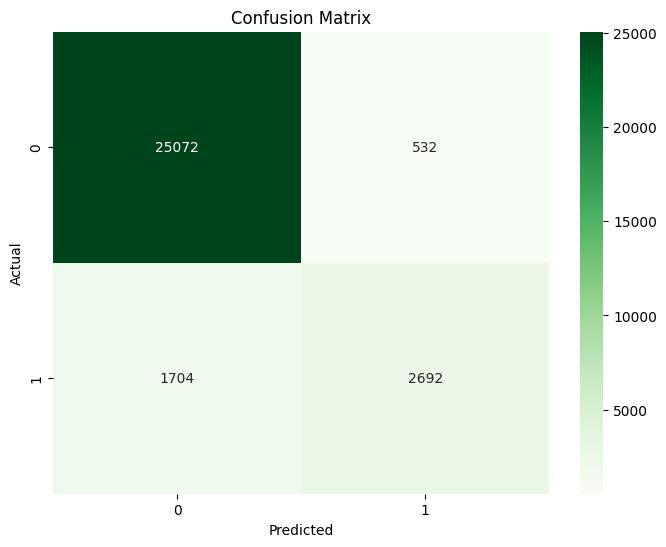

In [149]:
# Make predictions on the validation set
y_pred_val = loan_default_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_val)

_viz_name = 'eda/confusion matrix.png'
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

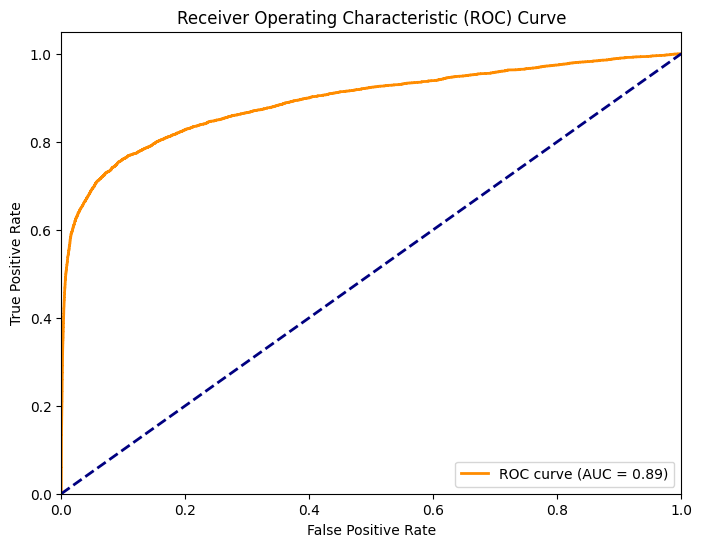

In [150]:
# Make predictions on the validation set
y_pred_val_proba = loan_default_model.predict_proba(X_test)[:, 1]  # Get the probability of default

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_val_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
_viz_name = 'eda/roc.png'
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

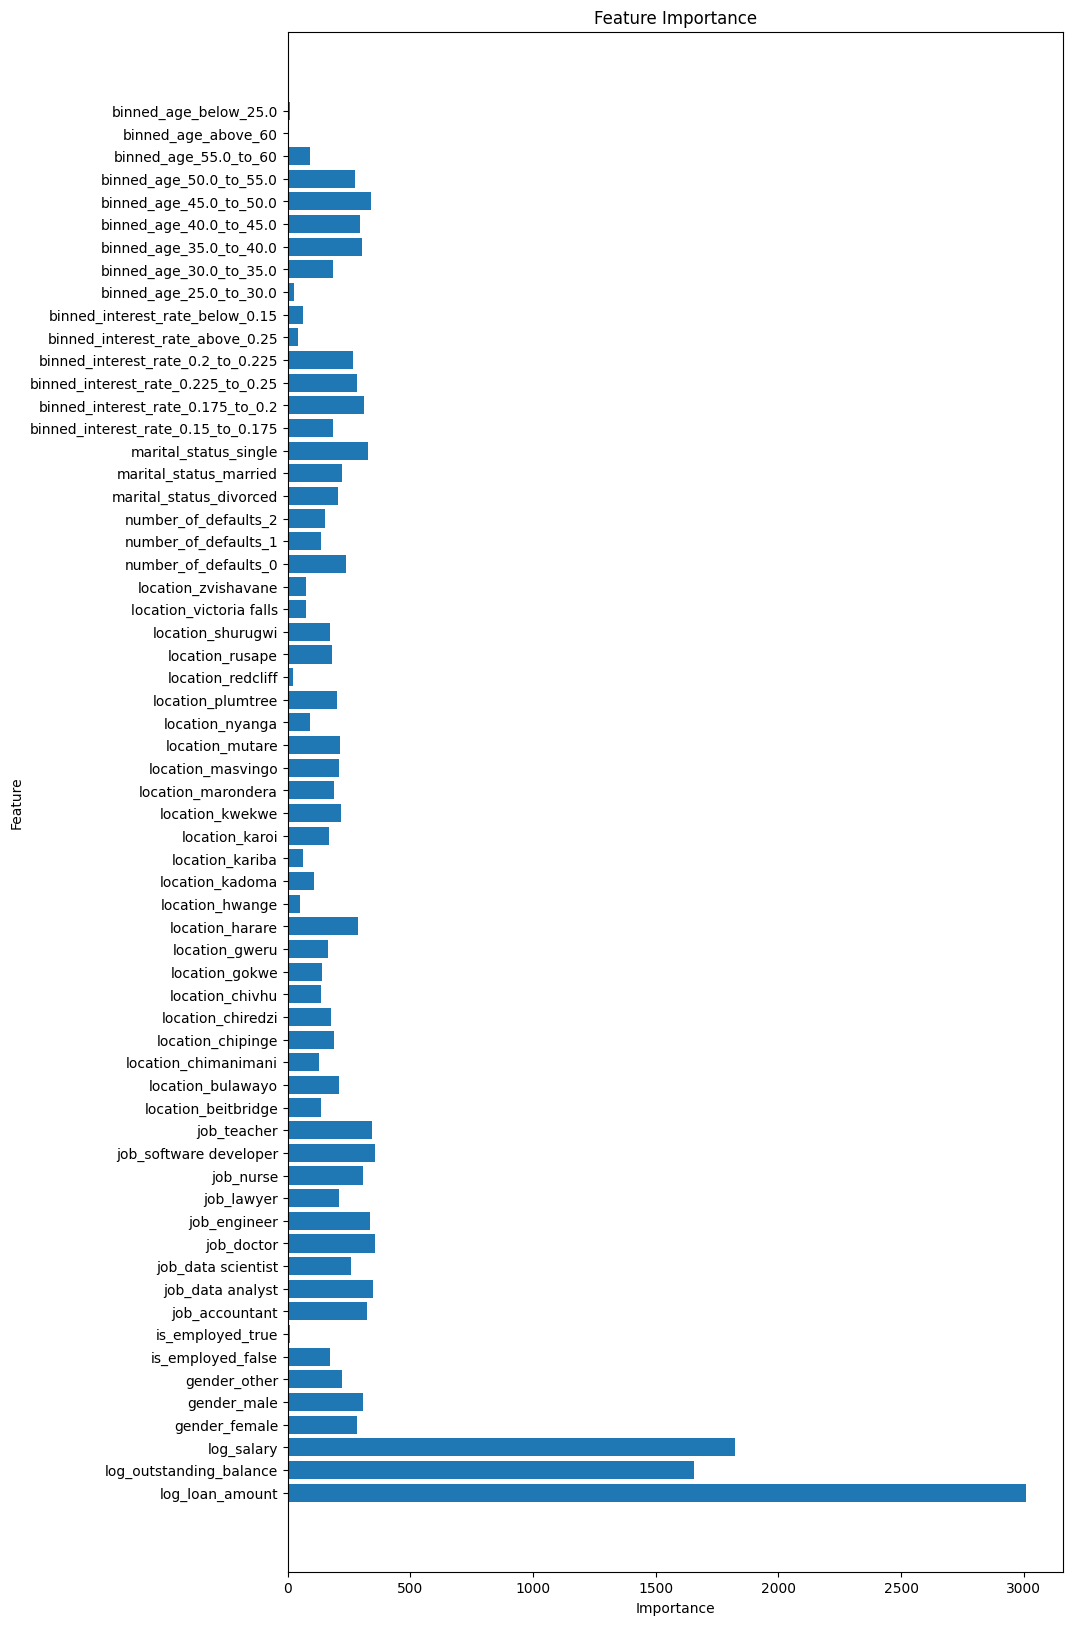

In [151]:
# Plot the feature importance
feature_importance = loan_default_model.feature_importances_
feature_names = X_test.columns

_viz_name = 'eda/feature importance.png'
# 
plt.figure(figsize=(10, 20))
plt.barh(feature_names, feature_importance)
# plt.xticks(rotation=60)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.savefig(_viz_name)
# Display the image
# Image(filename=_viz_name)

# Save model

- Training and storing the model and associated artifacts for future use, deployment, or further refinement.

## Section helper methods

In [152]:
def save_trained_model(_model, _model_name: str='loan_default_prediction'):
    # Check for any models in model deployment directory
    model_list = listdir(MODEL_DEPLOYMENT_DIR)

    # When model list exists
    check_name_count: int = 0
    if model_list:
        check_name_list = [model_name_ for model_name_ in model_list if _model_name in model_name_]
        check_name_count = len(check_name_list)

    # Indicate the nth of the coming report
    check_name_count += 1
    model_file_name = '{}/{}_{}.pkl'.format(MODEL_DEPLOYMENT_DIR, _model_name, check_name_count)
    
    # Save the model to a file
    joblib.dump(_model, model_file_name)

    # When report has been generated
    if exists(model_file_name):
        print('Model: {} successfully saved!'.format(model_file_name))

    else:
        print('No generated model!')

[CV] END learning_rate=0.07659795132692183, max_depth=18, n_estimators=239; total time= 9.5min


## Model saving process

In [153]:
save_trained_model(loan_default_model)

Model: deployed_models/loan_default_prediction_2.pkl successfully saved!
[CV] END algorithm=ball_tree, n_neighbors=9, weights=uniform; total time=12.3min
[CV] END learning_rate=0.07201574660182793, max_depth=19, n_estimators=123; total time= 4.6min
[CV] END learning_rate=0.07201574660182793, max_depth=19, n_estimators=123; total time= 4.5min
[CV] END learning_rate=0.07201574660182793, max_depth=19, n_estimators=123; total time= 4.6min
[CV] END algorithm=ball_tree, n_neighbors=9, weights=uniform; total time=11.0min
[CV] END learning_rate=0.07201574660182793, max_depth=19, n_estimators=123; total time= 4.8min
[CV] END learning_rate=0.07201574660182793, max_depth=19, n_estimators=123; total time= 4.7min
[CV] END algorithm=ball_tree, n_neighbors=9, weights=uniform; total time=11.3min
[CV] END ....algorithm=auto, n_neighbors=12, weights=uniform; total time=  23.7s
[CV] END ....algorithm=auto, n_neighbors=12, weights=uniform; total time=  23.1s
[CV] END ....algorithm=auto, n_neighbors=12, we